## **Import**

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

## **Data Cleaning & Transformation**

Summary of data cleaning & transformation step:



|No|Field Name|Description|Data Type|Cleaning & Transforming Steps|
|--|----------|-----------|---------|-----------------------------|
|1|ID|Customer's unique identifier|integer|Merge rows by ID to fill missing values in other columns|
|2|Year_Of_Birth|Customer's birth year|float|Extract age|
|3|Academic_Level|Customer's academic level|string|None|
|4|Income|Customer's yearly household income|float|Drop null values & outliers|
|5|Registration_Time|Date that customer enrolled with the company|string|Extract days since registration|
|6|Recency|Number of days since customer's last purchase|float|None|
|7|Liquor|Amount spent on liquor in last 2 years|float|None|
|8|Vegetables|Amount spent on vegetables in last 2 years|float|None|
|9|Pork|Amount spent on pork in last 2 years|float|None|
|10|Seafood|Amount spent on seafood in last 2 years|float|None|
|11|Candy|Amount spent on candy in last 2 years|float|None|
|12|Jewellery|Amount spent on jewellery in last 2 years|float|None|
|13|Num_Deals_Purchases|Number of purchases made with a discount|float|None|
|14|Num_Web_Purchases|Number of purchases made through the company’s website|float|None|
|15|Num_Catalog_Purchases|Number of purchases made using a catalogue|float|None|
|16|Num_Store_Purchases|Number of purchases made directly in stores|None|
|17|Num_Web_Visits_Month|Number of visits to company’s website in the last month|float|None|
|18|Promo_10|1 if customer accepted the offer in the 1st campaign, 0 otherwise|float|None|
|19|Promo_20|1 if customer accepted the offer in the 2nd campaign, 0 otherwise|float|None|
|20|Promo_30|1 if customer accepted the offer in the 3rd campaign, 0 otherwise|float|None|
|21|Promo_40|1 if customer accepted the offer in the 4th campaign, 0 otherwise|float|Drop due to unexplanable values|
|22|Promo_50|1 if customer accepted the offer in the 5th campaign, 0 otherwise|float|None|
|23|Complain|1 if the customer complained in the last 2 years, 0 otherwise|float|None|
|23|Gender|Customers' genders|string|None|
|24|Phone|Customers' phone|string|Merge with Phone_Number|
|25|Phone_Number|Customers' phone|string|Merge with Phone|
|26|Year_Register|Year that customer enrolled with the company|float|Drop|
|27|Month_Register|Month that customer enrolled with the company|float|Drop|
|28|Total_Purchase|Total purchases of the customer|float|Drop|
|29|Living_With|Marital status & number of children|float|Split to marital_status & number_of_children; convert "Alone" to "Single", drop "Absurd", "YOLO" values in marital_status|
|30|Payment_Method|Customers' payment method|string|Fill null values by "Unknown"|

In [964]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 2 to 3066
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       1228 non-null   int64         
 1   Year_Of_Birth            1228 non-null   float64       
 2   Academic_Level           1228 non-null   object        
 3   Income                   1228 non-null   float64       
 4   Registration_Time        1228 non-null   datetime64[ns]
 5   Recency                  1228 non-null   float64       
 6   Liquor                   1228 non-null   float64       
 7   Vegetables               1228 non-null   float64       
 8   Pork                     1228 non-null   float64       
 9   Seafood                  1228 non-null   float64       
 10  Candy                    1228 non-null   float64       
 11  Jewellery                1228 non-null   float64       
 12  Num_Deals_Purchases      1228 non-null 

In [965]:
# Read dataset
data = pd.read_csv("/data/data.csv", dtype = {'Phone' : str, 'Phone_Number': str})

In [966]:
data.head()

ID  Year_Of_Birth Academic_Level   Income Registration_Time  ...  \
0  6815         1982.0            PhD  30396.0        30-04-2023  ...   
1  2567            NaN            NaN  83532.0        26-09-2022  ...   
2  6053         1982.0            PhD  68682.0        06-10-2022  ...   
3  1985         2002.0            PhD  63516.0        06-07-2022  ...   
4  6860            NaN            PhD  51650.0        11-05-2023  ...   

   Year_Register  Month_Register  Total_Purchase  Living_With  Payment_Method  
0         2023.0             4.0             6.0    Married_1            Cash  
1            NaN             NaN            15.0   Together_0             NaN  
2         2022.0            10.0            24.0   Together_0            Cash  
3         2022.0             7.0            16.0   Together_2          Online  
4         2023.0             NaN            10.0    Married_1          Mobile  

[5 rows x 31 columns]

In [967]:
# Define function to display data types, number of missing values and % missing values
def display_missing_value(data):
    datatype = pd.DataFrame(data.dtypes,columns=["Data Type"])
    datatype["Missing Values"]=data.isnull().sum()
    datatype["% Missing Values"]=data.isnull().sum()/len(data)*100
    return datatype.sort_values(by="% Missing Values", ascending=False).style.background_gradient(cmap='tab20',axis=0).format({'% Missing Values': '{:.2f}%'})

In [968]:
display_missing_value(data)

### **Merge duplicate IDs**

In [969]:
# Check for duplicate ID
duplicate_mask = data.duplicated(subset=['ID'])
duplicates = data[duplicate_mask]
print(f"There are {len(duplicates['ID'].unique())} duplicate IDs")

There are 545 duplicate IDs


In [970]:
# Fill missing values in each group of ID by propagating non-null values forward and backward
data_filled = data.groupby('ID').apply(lambda group: group.fillna(method='bfill').fillna(method='ffill')).reset_index(drop=True)

In [971]:
data_filled

ID  Year_Of_Birth Academic_Level   Income Registration_Time  ...  \
0     1001         1994.0     Graduation  61074.0        17-08-2021  ...   
1     1002         1989.0     Graduation  60093.0        26-06-2022  ...   
2     1005         1978.0       2n Cycle  79689.0        12-05-2022  ...   
3     1006         1987.0         Master  41021.0        30-12-2021  ...   
4     1007         1996.0            PhD  57333.0        22-09-2021  ...   
...    ...            ...            ...      ...               ...  ...   
3064  9986         1990.0     Graduation  56628.0        21-03-2023  ...   
3065  9990         1993.0     Graduation  75330.0        04-10-2021  ...   
3066  9997         1994.0     Graduation  56243.0        30-12-2022  ...   
3067  9997         1994.0     Graduation  56243.0        30-12-2022  ...   
3068  9997         1994.0     Graduation  56243.0        30-12-2022  ...   

      Year_Register  Month_Register  Total_Purchase  Living_With  \
0               NaN             NaN            31.0    Married_1   
1               NaN             6.0            21.0    Married_1   
2            2022.0             5.0            27.0     Single_0   
3            2021.0             NaN             7.0   Together_1   
4            2021.0             9.0            33.0   Divorced_1   
...             ...             ...             ...          ...   
3064         2023.0             NaN            20.0     Single_1   
3065            NaN             NaN            29.0    Married_2   
3066         2022.0            12.0            20.0     Single_3   
3067         2022.0            12.0            20.0     Single_3   
3068         2022.0            12.0            20.0     Single_3   

      Payment_Method  
0               Card  
1             Mobile  
2             Online  
3             Online  
4               Card  
...              ...  
3064          Mobile  
3065          Online  
3066          Online  
3067          Online  
3068          Online  

[3069 rows x 31 columns]

In [972]:
# Drop all duplicate rows
data = data_filled.drop_duplicates()

In [973]:
# Check for duplicate ID again to see whether there is conflicting values within one ID (which resulting in two "non-duplicate" row and cannot be eliminated)
duplicate_mask = data.duplicated(subset=['ID'])
duplicates = data[duplicate_mask]
print(f"There are {len(duplicates['ID'].unique())} duplicate IDs")

There are 0 duplicate IDs


In [974]:
display_missing_value(data)

### **Merge Phone and Phone_Number columns**

In [975]:
# Check whether there is any row that has confliting "Phone" and "Phone_Number" values
data[data['Phone'].notnull() & data['Phone_Number'].notnull() & (data['Phone'] != data['Phone_Number'])]

Empty DataFrame
Columns: [ID, Year_Of_Birth, Academic_Level, Income, Registration_Time, Recency, Liquor, Vegetables, Pork, Seafood, Candy, Jewellery, Num_Deals_Purchases, Num_Web_Purchases, Num_Catalog_Purchases, Num_Store_Purchases, Num_Web_Visits_Month, Promo_30, Promo_40, Promo_50, Promo_10, Promo_20, Complain, Gender, Phone, Phone_Number, Year_Register, Month_Register, Total_Purchase, Living_With, Payment_Method]
Index: []

[0 rows x 31 columns]

In [976]:
# Merge two columns 'Phone' and 'Phone Number'.
# The new value will be:
# 1. NaN if both columns are NaN
# 2. The value from one column if neither of them or only one of them is NaN
def concat_with_nan(row):

    # Check if both 'Phone' and 'Phone_Number' are NaN, return NaN
    if pd.isna(row['Phone']) and pd.isna(row['Phone_Number']):
        return np.nan

    # Check if both 'Phone' and 'Phone_Number' are not NaN, return one of them
    elif not pd.isna(row['Phone']) and not pd.isna(row['Phone_Number']):
        return row['Phone']

    # If only one of 'Phone' or 'Phone_Number' is NaN, return the non-NaN value
    else:
        return "".join(filter(pd.notna, [row['Phone'], row['Phone_Number']]))

# Apply the custom function to each row
data['Phone'] = data.apply(concat_with_nan, axis=1)
data = data.drop(columns = ["Phone_Number"])

In [977]:
data.head()

ID  Year_Of_Birth Academic_Level   Income Registration_Time  ...  \
0  1001         1994.0     Graduation  61074.0        17-08-2021  ...   
1  1002         1989.0     Graduation  60093.0        26-06-2022  ...   
2  1005         1978.0       2n Cycle  79689.0        12-05-2022  ...   
3  1006         1987.0         Master  41021.0        30-12-2021  ...   
4  1007         1996.0            PhD  57333.0        22-09-2021  ...   

   Year_Register  Month_Register  Total_Purchase  Living_With  Payment_Method  
0            NaN             NaN            31.0    Married_1            Card  
1            NaN             6.0            21.0    Married_1          Mobile  
2         2022.0             5.0            27.0     Single_0          Online  
3         2021.0             NaN             7.0   Together_1          Online  
4         2021.0             9.0            33.0   Divorced_1            Card  

[5 rows x 30 columns]

In [978]:
display_missing_value(data)

In [979]:
# Check for duplicate phone numbers
duplicate_mask = data.duplicated(subset=['Phone'])
duplicates = data[duplicate_mask]
print(f"There are {len(duplicates['Phone'].unique())} duplicate phone numbers")

There are 0 duplicate phone numbers


### **Registration_Time to Days_SInce_Registration**

In [980]:
# Convert Registration_Time to datetime
data['Registration_Time'] = pd.to_datetime(data['Registration_Time'], format='%d-%m-%Y')

In [981]:
data['Registration_Time'].info()

<class 'pandas.core.series.Series'>
Index: 2240 entries, 0 to 3066
Series name: Registration_Time
Non-Null Count  Dtype         
--------------  -----         
2240 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 35.0 KB


In [982]:
# I assume that the record date (the date on which the data is recorded) is calculated as:
# the maximum date found in the 'Registration_Time' column plus the number of days in the 'Recency' column.
record_date = (data['Registration_Time'] + pd.to_timedelta(data['Recency'], unit='D')).max()
data['Days_Since_Registration'] = (record_date - data['Registration_Time']).dt.days
data['Days_Since_Registration'].head()

0    778
1    465
2    510
3    643
4    742
Name: Days_Since_Registration, dtype: int64

### **Null values in Payment_Method**

In [983]:
data['Payment_Method'] = data['Payment_Method'].fillna('Unknown')

### **Null values in Income**

In [984]:
data = data.dropna(subset=['Income'])

### **Null values in Registration Month and Year**

In [985]:
data = data.dropna(subset=['Year_Register', 'Month_Register'])

In [986]:
display_missing_value(data)

### **Split Living_With**

In [987]:
# Split Living_With
def marital_status(row):
    return row['Living_With'][:-2]

def child(row):
    return row['Living_With'][-1:]

In [988]:
# Apply the custom function to each row
data['Marital_Status'] = data.apply(marital_status, axis=1)
data['Number_Of_Children'] = pd.to_numeric(data.apply(child, axis=1), errors='coerce')
data = data.drop(columns=['Living_With'])

### **Age**

In [989]:
# Calculate the age
def age(row):
    return 2024 - row['Year_Of_Birth']

In [990]:
data['Age'] = data.apply(age, axis=1)

In [991]:
data.head()

ID  Year_Of_Birth Academic_Level   Income Registration_Time  ...  \
2   1005         1978.0       2n Cycle  79689.0        2022-05-12  ...   
4   1007         1996.0            PhD  57333.0        2021-09-22  ...   
5   1008         1996.0            PhD  75032.0        2022-04-28  ...   
9   1018         1990.0     Graduation  31814.0        2022-02-09  ...   
11  1022         1985.0     Graduation  75693.0        2021-12-06  ...   

    Payment_Method  Days_Since_Registration  Marital_Status  \
2           Online                      510          Single   
4             Card                      742        Divorced   
5             Cash                      524         Married   
9          Unknown                      602         Married   
11          Online                      667        Divorced   

    Number_Of_Children   Age  
2                    0  46.0  
4                    1  28.0  
5                    1  28.0  
9                    1  34.0  
11                   0  39.0  

[5 rows x 33 columns]

In [992]:
data.head()

ID  Year_Of_Birth Academic_Level   Income Registration_Time  ...  \
2   1005         1978.0       2n Cycle  79689.0        2022-05-12  ...   
4   1007         1996.0            PhD  57333.0        2021-09-22  ...   
5   1008         1996.0            PhD  75032.0        2022-04-28  ...   
9   1018         1990.0     Graduation  31814.0        2022-02-09  ...   
11  1022         1985.0     Graduation  75693.0        2021-12-06  ...   

    Payment_Method  Days_Since_Registration  Marital_Status  \
2           Online                      510          Single   
4             Card                      742        Divorced   
5             Cash                      524         Married   
9          Unknown                      602         Married   
11          Online                      667        Divorced   

    Number_Of_Children   Age  
2                    0  46.0  
4                    1  28.0  
5                    1  28.0  
9                    1  34.0  
11                   0  39.0  

[5 rows x 33 columns]

### **Promoto_40**

In [993]:
# Check how many rows that have Promo_40 value equal to -1
data[data['Promo_40'] == -1]

ID  Year_Of_Birth Academic_Level   Income Registration_Time  ...  \
2     1005         1978.0       2n Cycle  79689.0        2022-05-12  ...   
4     1007         1996.0            PhD  57333.0        2021-09-22  ...   
5     1008         1996.0            PhD  75032.0        2022-04-28  ...   
11    1022         1985.0     Graduation  75693.0        2021-12-06  ...   
12    1028         1985.0            PhD  40344.0        2022-10-13  ...   
...    ...            ...            ...      ...               ...  ...   
3054  9963         1988.0     Graduation  34600.0        2022-01-01  ...   
3055  9967         1988.0     Graduation  36065.0        2022-03-31  ...   
3056  9970         1987.0         Master  59354.0        2022-11-15  ...   
3061  9980         1992.0     Graduation  22010.0        2022-06-30  ...   
3066  9997         1994.0     Graduation  56243.0        2022-12-30  ...   

      Payment_Method  Days_Since_Registration  Marital_Status  \
2             Online                      510          Single   
4               Card                      742        Divorced   
5               Cash                      524         Married   
11            Online                      667        Divorced   
12              Cash                      356         Married   
...              ...                      ...             ...   
3054          Online                      641        Together   
3055          Mobile                      552          Single   
3056            Card                      323        Divorced   
3061          Online                      461        Together   
3066          Online                      278          Single   

      Number_Of_Children   Age  
2                      0  46.0  
4                      1  28.0  
5                      1  28.0  
11                     0  39.0  
12                     1  39.0  
...                  ...   ...  
3054                   2  36.0  
3055                   2  36.0  
3056                   2  37.0  
3061                   1  32.0  
3066                   3  30.0  

[820 rows x 33 columns]

There are a lot of rows with promote_40 = -1, so I won't delete these. However, I will not use them in the clustering.

### **Weirds value in categorical attributes**

In [994]:
categories = list(data.select_dtypes(include='object').columns)

In [995]:
categories

['Academic_Level', 'Gender', 'Phone', 'Payment_Method', 'Marital_Status']

#### Academic_Level

In [996]:
data['Academic_Level'].unique()

array(['2n Cycle', 'PhD', 'Graduation', 'Master', 'Basic'], dtype=object)

#### Gender

In [997]:
data['Gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

#### Payment_Method

In [998]:
data['Payment_Method'].unique()

array(['Online', 'Card', 'Cash', 'Unknown', 'Mobile'], dtype=object)

#### Maritial_Status

In [999]:
data['Marital_Status'].unique()

array(['Single', 'Divorced', 'Married', 'Together', 'Widow', 'Alone'],
      dtype=object)

Convert 'Alone' to 'Single'

In [1000]:
data['Marital_Status'] = data['Marital_Status'].replace('Alone', 'Single')

In [1001]:
# Check how many row that have Absurb and YOLO values
data[data['Marital_Status'].isin(['Absurd', 'YOLO'])]

Empty DataFrame
Columns: [ID, Year_Of_Birth, Academic_Level, Income, Registration_Time, Recency, Liquor, Vegetables, Pork, Seafood, Candy, Jewellery, Num_Deals_Purchases, Num_Web_Purchases, Num_Catalog_Purchases, Num_Store_Purchases, Num_Web_Visits_Month, Promo_30, Promo_40, Promo_50, Promo_10, Promo_20, Complain, Gender, Phone, Year_Register, Month_Register, Total_Purchase, Payment_Method, Days_Since_Registration, Marital_Status, Number_Of_Children, Age]
Index: []

[0 rows x 33 columns]

In [1002]:
# Drop Absurb and YOLO
data = data[~data['Marital_Status'].isin(['Absurd', 'YOLO'])]

### **Outliers in numeric attributes**

In [1003]:
# To view the whole dataframe
pd.set_option('display.max_columns', None)
# Calculate statistical values of each attributes
data.drop(columns=['Promo_10', 'Promo_20', 'Promo_30', 'Promo_40', 'Promo_50', 'ID', 'Registration_Time', 'Complain']).describe()

Year_Of_Birth         Income      Recency       Liquor   Vegetables  \
count    1228.000000    1228.000000  1228.000000  1228.000000  1228.000000   
mean     1987.960912   52070.547231    49.715798   300.567590    27.754886   
std         4.976892   27658.682907    28.888705   333.008388    39.115248   
min      1975.000000    2447.000000     0.000000     1.000000     2.000000   
25%      1984.750000   35642.250000    25.000000    25.750000     3.000000   
50%      1988.000000   50694.500000    50.000000   173.500000    10.000000   
75%      1991.000000   68352.500000    74.000000   495.000000    34.000000   
max      2002.000000  666666.000000    99.000000  1493.000000   201.000000   

              Pork      Seafood        Candy    Jewellery  \
count  1228.000000  1228.000000  1228.000000  1228.000000   
mean    169.281759    37.888436    27.600977    43.712541   
std     231.527775    55.472599    41.696584    51.338748   
min       0.000000     0.000000     0.000000     0.000000   
25%      16.000000     3.000000     1.000000     9.000000   
50%      66.500000    12.000000     8.000000    24.000000   
75%     230.000000    50.000000    35.000000    56.000000   
max    1725.000000   258.000000   262.000000   321.000000   

       Num_Deals_Purchases  Num_Web_Purchases  Num_Catalog_Purchases  \
count          1228.000000        1228.000000            1228.000000   
mean              2.389251           4.119707               2.612378   
std               1.968360           2.751217               2.907357   
min               0.000000           0.000000               0.000000   
25%               1.000000           2.000000               0.000000   
50%               2.000000           4.000000               2.000000   
75%               3.000000           6.000000               4.000000   
max              15.000000          27.000000              28.000000   

       Num_Store_Purchases  Num_Web_Visits_Month  Year_Register  \
count          1228.000000           1228.000000    1228.000000   
mean              5.755700              5.372964    2022.023616   
std               3.215527              2.418211       0.695963   
min               0.000000              0.000000    2021.000000   
25%               3.000000              4.000000    2022.000000   
50%               5.000000              6.000000    2022.000000   
75%               8.000000              7.000000    2023.000000   
max              13.000000             20.000000    2023.000000   

       Month_Register  Total_Purchase  Days_Since_Registration  \
count     1228.000000     1228.000000              1228.000000   
mean         6.394951       14.877036               454.276873   
std          3.491455        7.676764               205.072635   
min          1.000000        0.000000                97.000000   
25%          3.000000        8.000000               274.750000   
50%          6.000000       15.000000               462.000000   
75%         10.000000       21.000000               631.250000   
max         12.000000       44.000000               796.000000   

       Number_Of_Children          Age  
count         1228.000000  1228.000000  
mean             0.947883    36.039088  
std              0.746993     4.976892  
min              0.000000    22.000000  
25%              0.000000    33.000000  
50%              1.000000    36.000000  
75%              1.000000    39.250000  
max              3.000000    49.000000

In [1004]:
# Reset the maximum columns displayed
pd.set_option('display.max_columns', 10)

In [1005]:
numeric_columns = list(data.select_dtypes(include='number').drop(columns=[f'Promo_{i}0' for i in [1, 2, 3, 4, 5]] + ['ID', 'Complain', 'Year_Register', 'Month_Register']).columns)

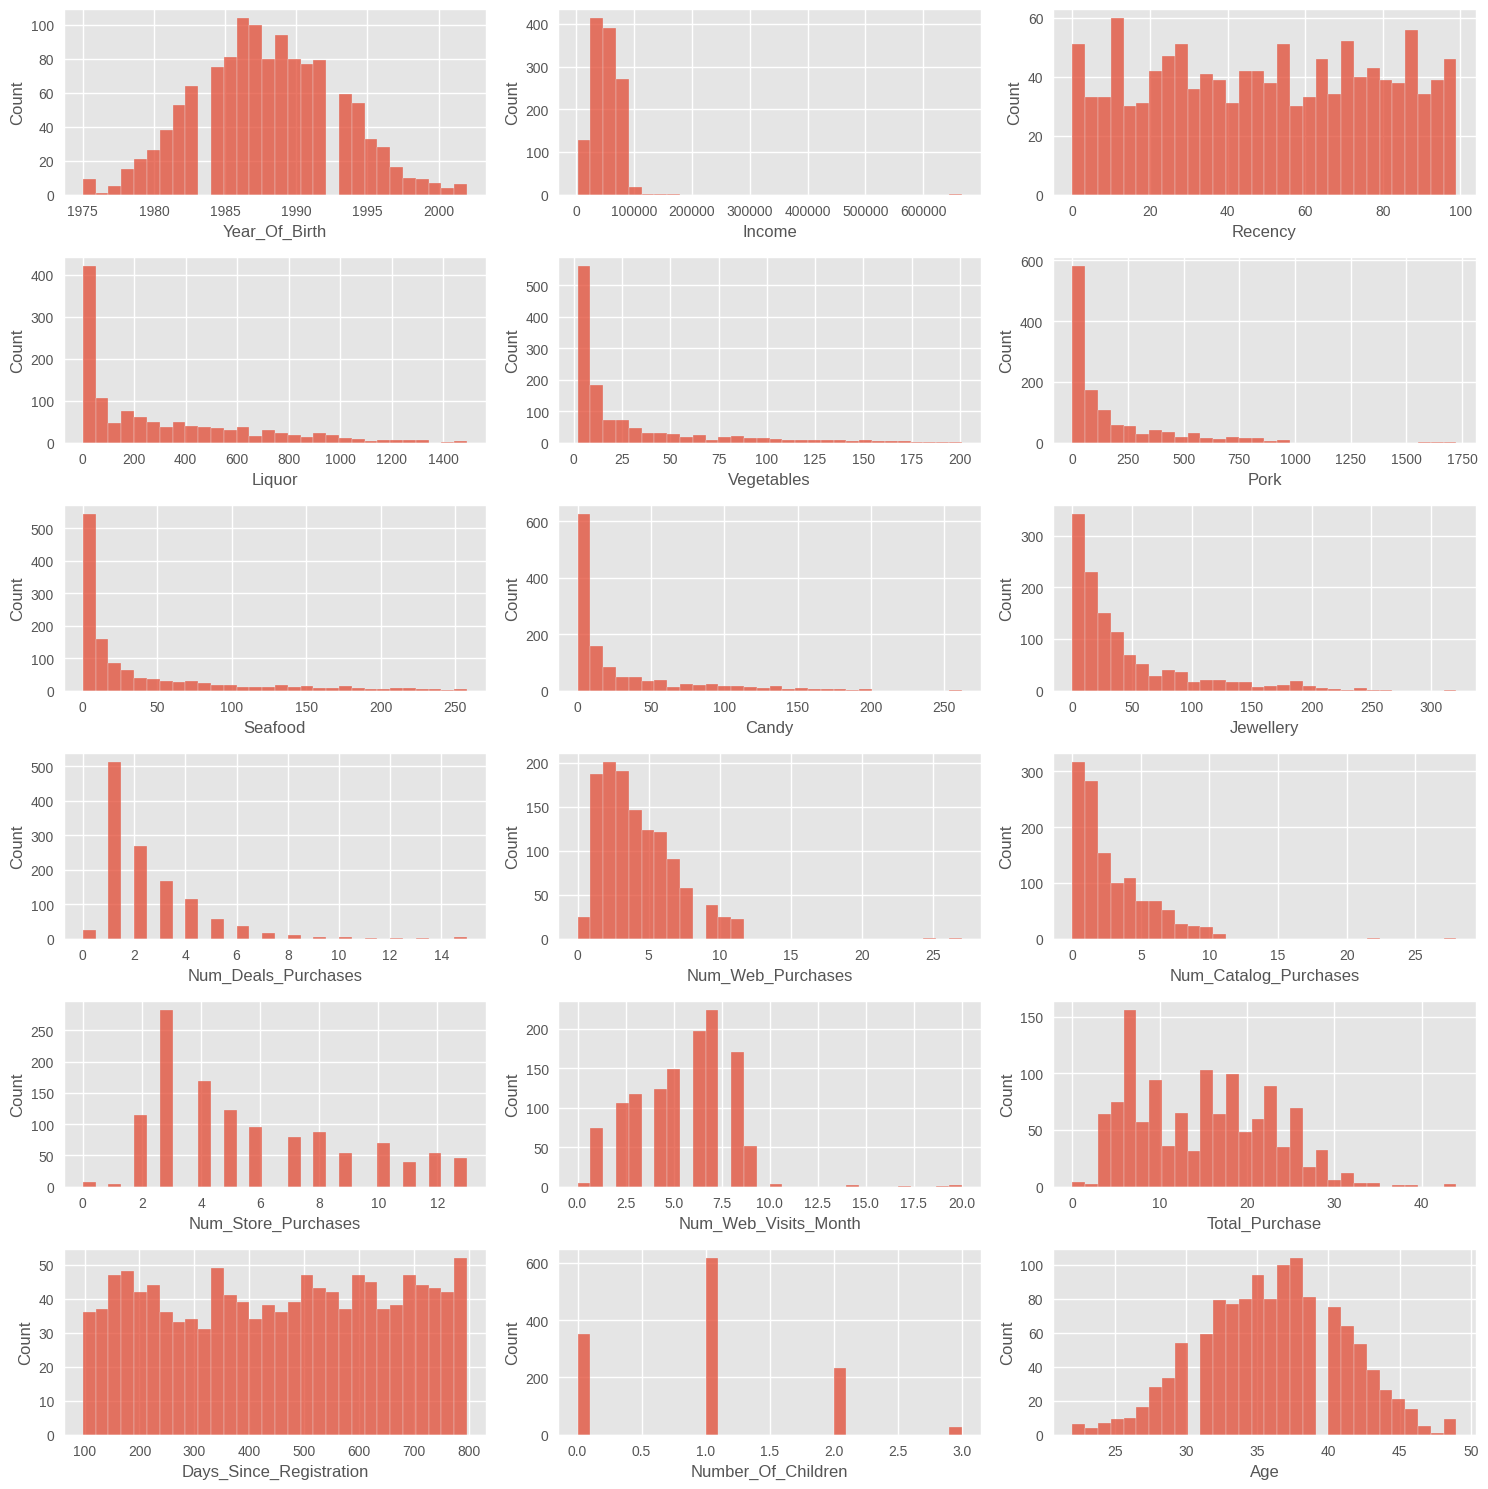

In [1006]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,15))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, ax in enumerate(axes.flat):
    if i < len(numeric_columns):
        sns.histplot(data[numeric_columns[i]], bins=30, linewidth=0.2, ax=ax)

fig.tight_layout()
plt.show()

Based on the range of attributes, Income appears to be the only attribute with abnormal values relative to its expected range. Thus I will only drop outliers in Income.


In [1007]:
columns = ['Income']

# Calculate the IQR for each column
Q1 = data[columns].quantile(0.25)
Q3 = data[columns].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold to identify outliers
threshold = 1.5

# Identify and remove outliers
data_outliers_cleaned = data.copy()  # Create a copy of the original DataFrame
for col in columns:
    #lower_bound = Q1[col] - threshold * IQR[col]
    upper_bound = Q3[col] + threshold * IQR[col]
    outliers = (data_outliers_cleaned[col] > upper_bound)
    data_outliers_cleaned = data_outliers_cleaned[~outliers]

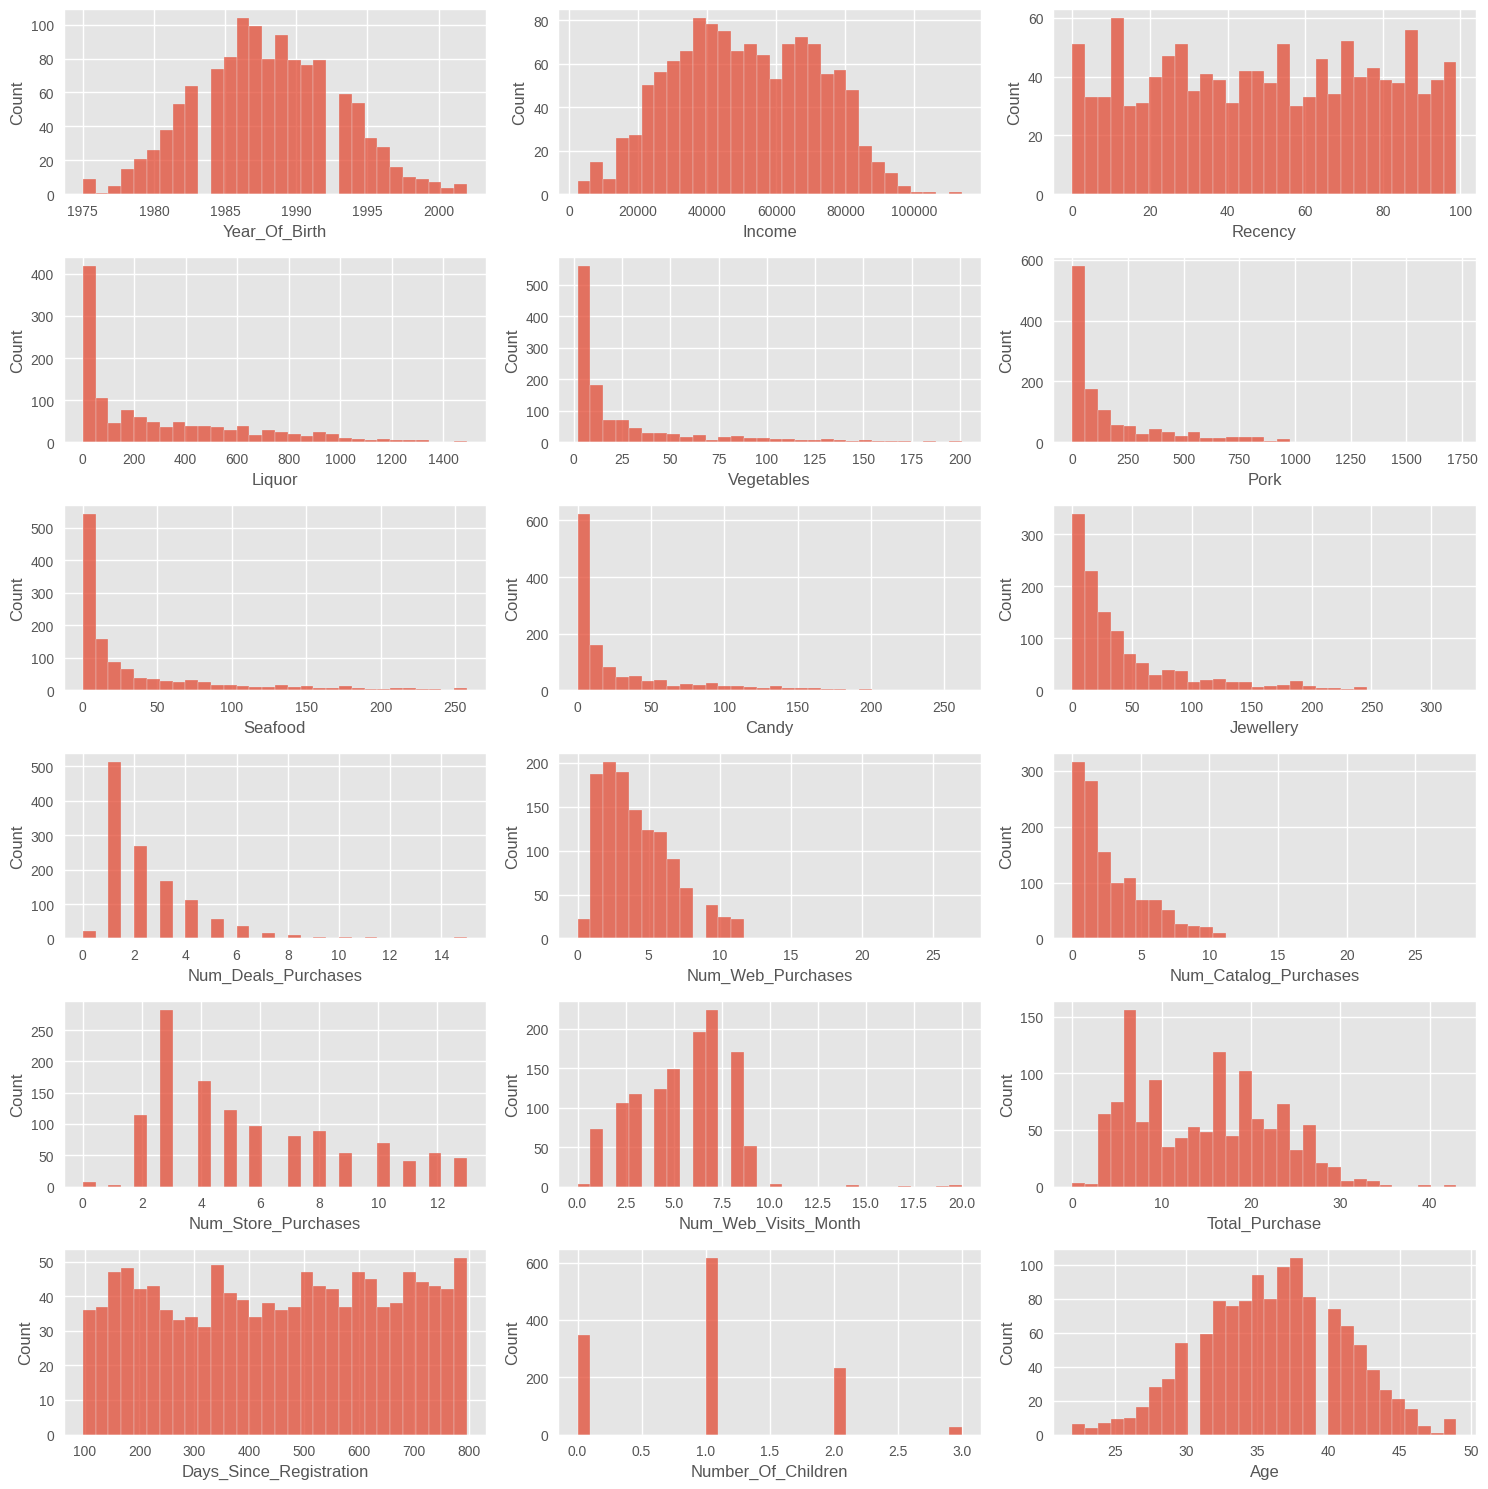

In [1008]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,15))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, ax in enumerate(axes.flat):
    if i < len(numeric_columns):
        sns.histplot(data_outliers_cleaned[numeric_columns[i]], bins=30, linewidth=0.2, ax=ax)

fig.tight_layout()
plt.show()

## **EDA**

**EDA Summary:**

1. Most customers at this store have partners.

2. Many customers are highly educated, with only a small portion having basic education.

3. Liquor shows the highest spending levels, significantly ahead of other categories, possibly due to its high cost or the store's specialization in liquor. Pork follows as the second highest, with other categories considerably lower.

4. Promo_30 is the most effective promotion for retaining customers or encouraging repeat purchases.

5. Customers with basic education generally have lower incomes, distributed at lower levels compared to other education groups.

6. A $100 increase in Annual Income predicts a 7.25% increase in Monthly Spending.

7. Every $100 rise in Monthly Income is expected to increase the percentage spent on Liquor by approximately 1%.

8. All marital status groups tend to spend less and tend to accept more discounts with more children.

9. The majority of purchases are made directly from the store.

10. Customers with basic education appear to make fewer purchases, likely due to their lower incomes.

11. On average, customers have a 37-day interval between purchases, with some infrequent buyers—over 25% have intervals exceeding 50 days, and some even surpass 100 days.

12. Some customers have a Recency-Average Interval Rate exceeding 5, suggesting they may no longer be active buyers.

### Distribution by marital status & academic level

#### Marital Status

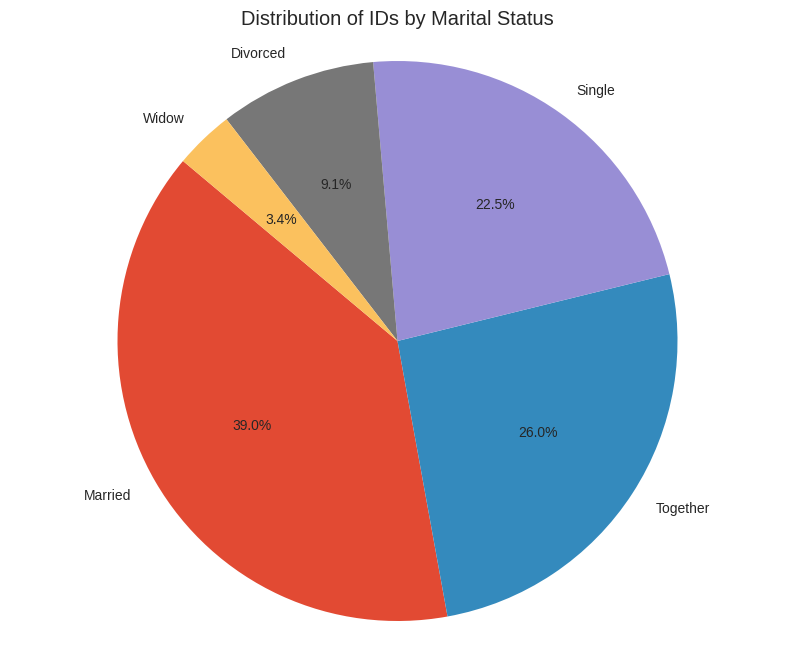

In [1009]:
# Count the number of IDs in each Marital Status
marital_status_counts = data_outliers_cleaned['Marital_Status'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of IDs by Marital Status')
plt.axis('equal')
plt.show()

We can see that most of the customers of this store have partners.



#### Academic Level

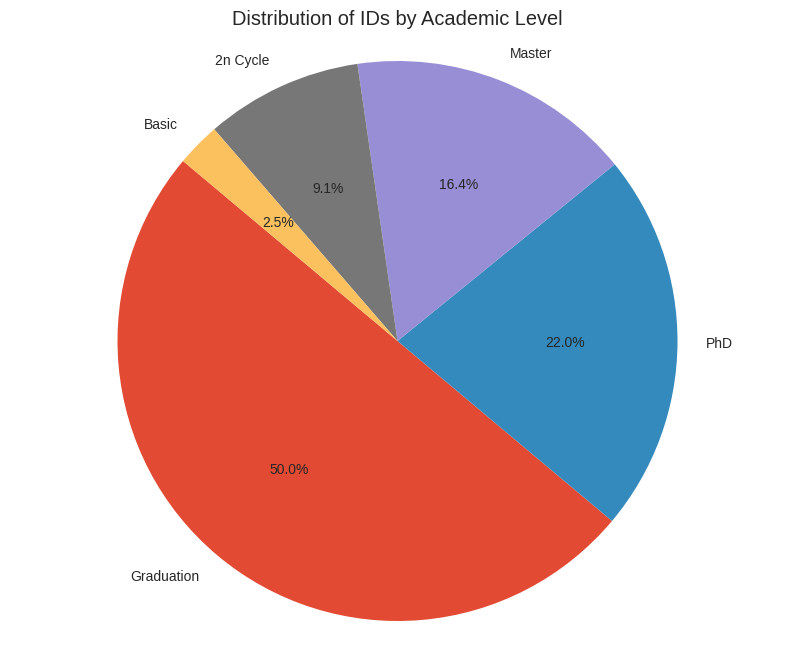

In [1010]:
# Count the number of IDs in each Academic Level
academic_level_counts = data_outliers_cleaned['Academic_Level'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(academic_level_counts, labels=academic_level_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of IDs by Academic Level')
plt.axis('equal')
plt.show()

We can see that a lot of customers in this store have high level of education and only a small portion have basic level.

### Product

#### Average percentage of each product purchased by customers

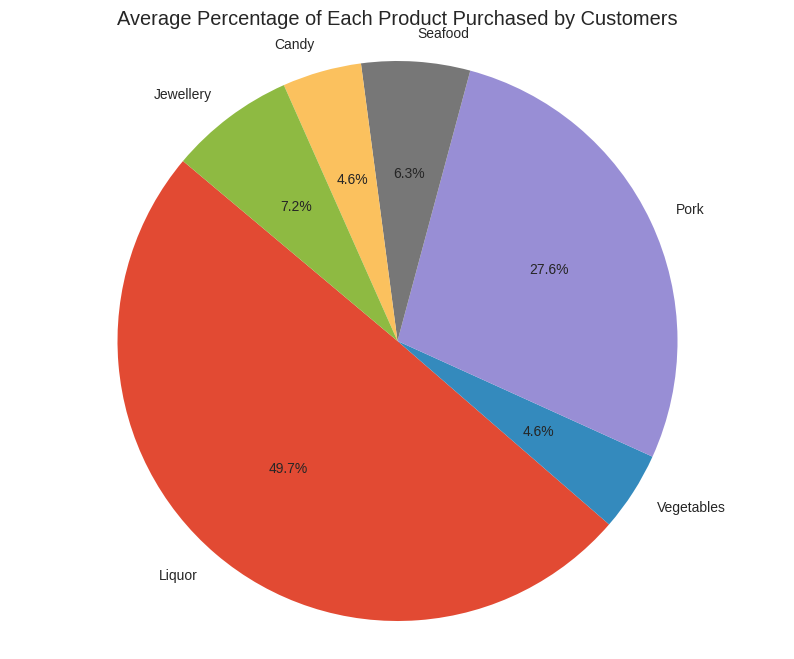

In [1011]:
product_columns = ['Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery']

# Calculate the average amount of each product purchased
average_products = data_outliers_cleaned[product_columns].mean()

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(average_products, labels=average_products.index, autopct='%1.1f%%', startangle=140)
plt.title('Average Percentage of Each Product Purchased by Customers')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

#### Total amount spent for product by age

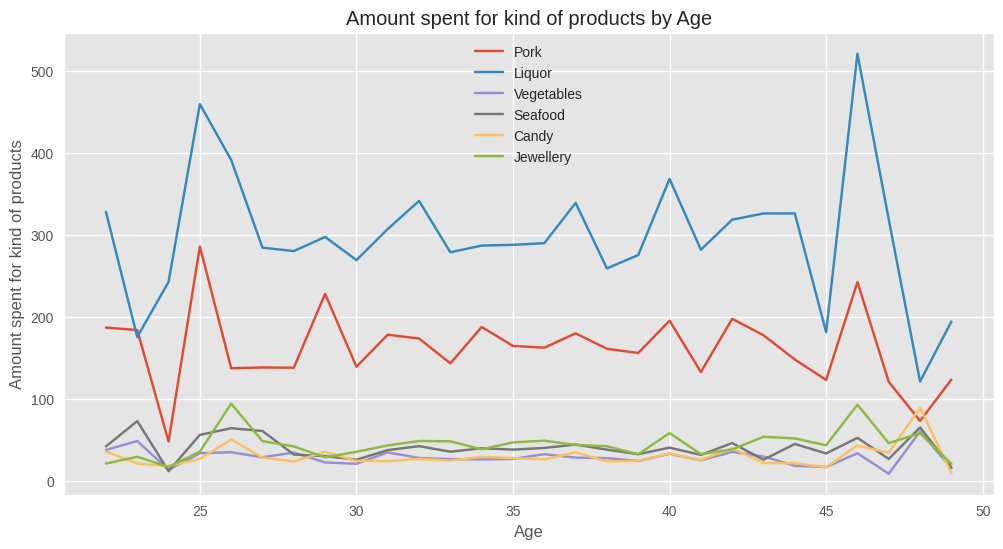

In [1012]:
plt.figure(figsize=(12, 6))

pork_by_age = data_outliers_cleaned.groupby('Age')['Pork'].agg(['mean'])
liquor_by_age = data_outliers_cleaned.groupby('Age')['Liquor'].agg(['mean'])
vegetables_by_age = data_outliers_cleaned.groupby('Age')['Vegetables'].agg(['mean'])
seafood_by_age = data_outliers_cleaned.groupby('Age')['Seafood'].agg(['mean'])
candy_by_age = data_outliers_cleaned.groupby('Age')['Candy'].agg(['mean'])
jewellery_by_age = data_outliers_cleaned.groupby('Age')['Jewellery'].agg(['mean'])

# Plot each line
plt.plot(pork_by_age.index, pork_by_age.values, label = 'Pork')
plt.plot(liquor_by_age.index, liquor_by_age.values, label = 'Liquor')
plt.plot(vegetables_by_age.index, vegetables_by_age.values, label = 'Vegetables')
plt.plot(seafood_by_age.index, seafood_by_age.values, label = 'Seafood')
plt.plot(candy_by_age.index, candy_by_age.values, label = 'Candy')
plt.plot(jewellery_by_age.index, jewellery_by_age.values, label = 'Jewellery')


# Add labels and tickers
plt.xlabel('Age')
plt.ylabel('Amount spent for kind of products')
plt.title('Amount spent for kind of products by Age')
plt.legend()

plt.show()

Liquor has the highest spending level, with significant gaps compared to other categories. This could be due to the high cost of liquor or because this store specializes in liquor.

### Promotion

In [1013]:
promo_columns = ['Promo_10', 'Promo_20', 'Promo_30', 'Promo_40', 'Promo_50']

In [1014]:
# Initialize lists to store the total number of acceptances and recurrent number of acceptances
total_acceptances = []
recurrent_acceptances = []
data_promo = data_outliers_cleaned.copy()
data_promo['Promo_40'] = data_outliers_cleaned['Promo_40'].replace(-1, 0)

for i in range(0, len(promo_columns)):
    total_acceptances.append(data_promo[promo_columns[i]].sum())

for i in range(0, len(promo_columns)-1):
    curr_promo = promo_columns[i]
    next_promo = promo_columns[i+1]

    # Calculate recurrent acceptances (i.e. among those who accept current promotion, how many accept the next promotion)
    recurrent_acceptances.append(data_promo[data_promo[curr_promo] == 1][next_promo].sum())

recurrent_acceptances.append(0) # For promotion 5

recurrent_acceptances = np.array(recurrent_acceptances)
non_recurrent_acceptances = total_acceptances-recurrent_acceptances

Recurrent acceptences means customers who recurrently accept the next promotion.

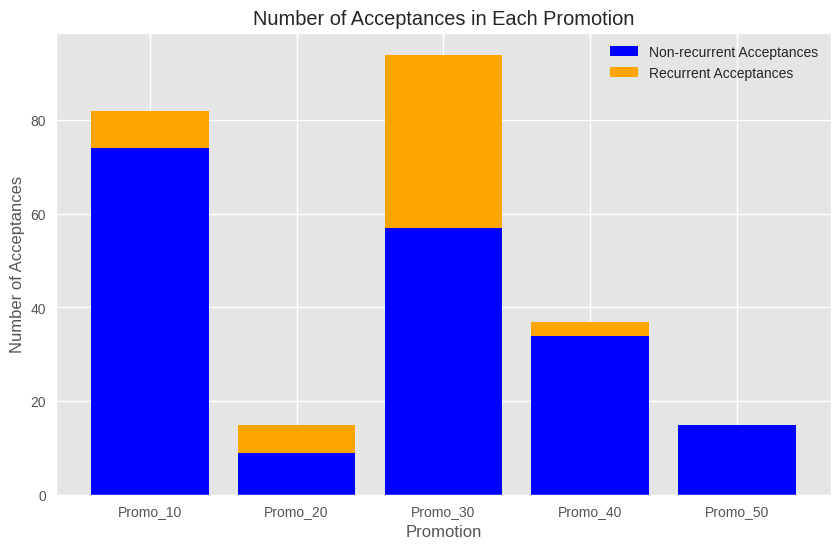

In [1015]:
# Create a bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(promo_columns, non_recurrent_acceptances, color='blue', label='Non-recurrent Acceptances')
plt.bar(promo_columns, recurrent_acceptances, color='orange', label='Recurrent Acceptances', bottom=non_recurrent_acceptances)

# Add labels and title
plt.xlabel('Promotion')
plt.ylabel('Number of Acceptances')
plt.title('Number of Acceptances in Each Promotion')
plt.legend()

# Show plot
plt.show()

Despite the false value of -1 in Promo_40, Promo_30 still has the highest recurrence rate. This indicates that Promo_30 is the most effective promotion in retaining customers or encouraging repeat purchases, regardless of any anomalies in the data for Promo_40.

### Income

#### Distribution of income level

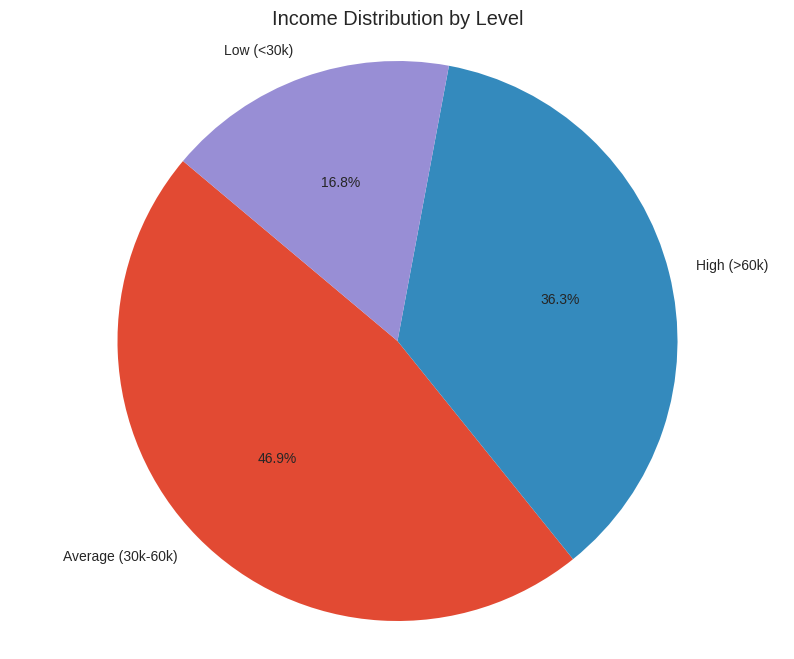

In [1016]:
# Categorize the income levels
income_bins = [0, 30000, 60000, float('inf')]
income_labels = ['Low (<30k)', 'Average (30k-60k)', 'High (>60k)']
data_outliers_cleaned['Income_Level'] = pd.cut(data_outliers_cleaned['Income'], bins=income_bins, labels=income_labels, right=False)

# Count the number of customers in each income level
income_level_counts = data_outliers_cleaned['Income_Level'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(income_level_counts, labels=income_level_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Income Distribution by Level')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

#### Income on academic level

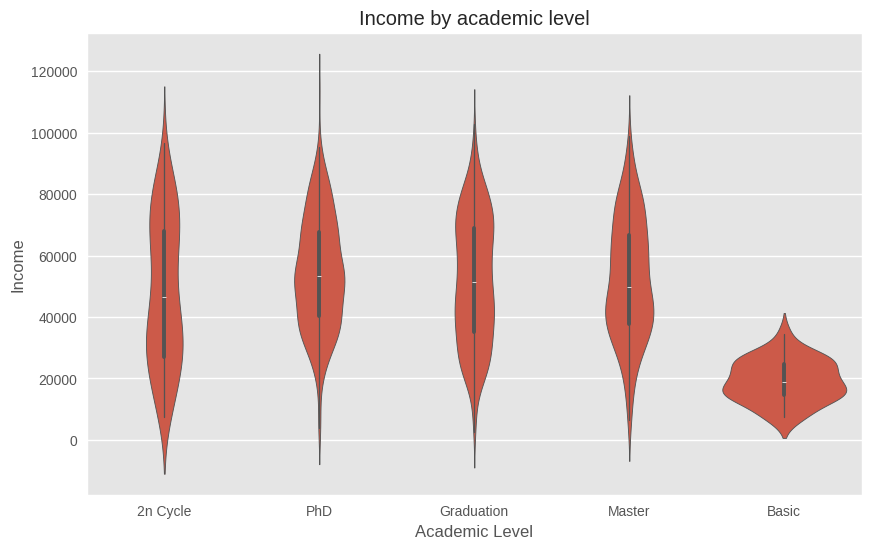

In [1017]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Academic_Level', y='Income', data=data_outliers_cleaned)
plt.title('Income by academic level')
plt.xlabel('Academic Level')
plt.ylabel('Income')
plt.show()

People with basic level of education has a lower median of income than other groups, and is generally distributed at lower values than other groups. But this difference may be due to the low sample size.

#### Income ~ Monthly Spending Since Registration

Because customers have different subscription periods (ranging from 0 days to 699 days), total_spending cannot reflect the relationship between income (ability to pay) and payment level (if any) -> I will take monthly spending calculated as total_spending/months since registration to represent the level of payment to the business.

**Months since Registration_Time**

In [1018]:
# Month since registration will be equals to days since registration divided by 12
data_outliers_cleaned['Month_Since_Registration'] = (record_date - data_outliers_cleaned['Registration_Time']) // pd.Timedelta(days=30)
data_outliers_cleaned['Month_Since_Registration'].head()

2     17
4     24
5     17
9     20
11    22
Name: Month_Since_Registration, dtype: int64

In [1019]:
data_outliers_cleaned['Total_Spending'] = data_outliers_cleaned['Pork'] + data_outliers_cleaned['Vegetables'] + data_outliers_cleaned['Liquor'] + data_outliers_cleaned['Jewellery'] + data_outliers_cleaned['Seafood'] + data_outliers_cleaned['Candy']

In [1020]:
data_outliers_cleaned['Monthly_Spending'] = data_outliers_cleaned['Total_Spending'] / (data_outliers_cleaned['Month_Since_Registration'].replace(0, np.nan))

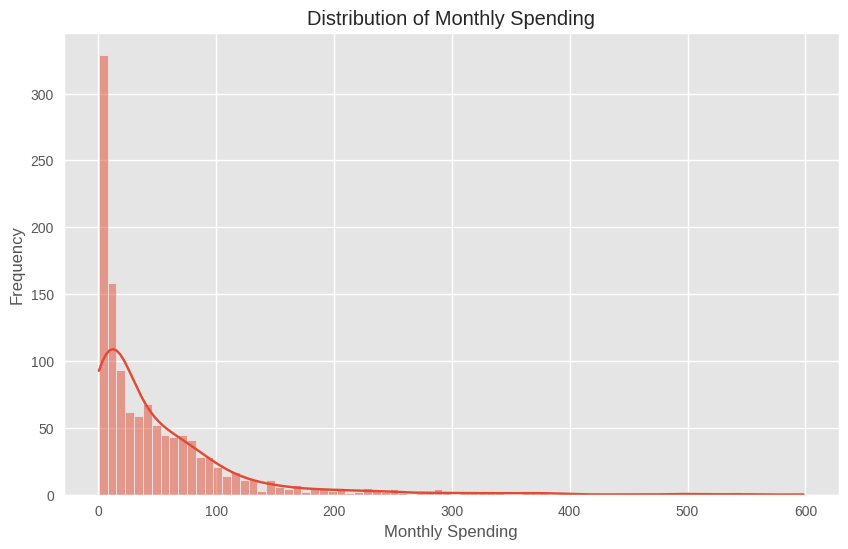

In [1021]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_outliers_cleaned['Monthly_Spending'], bins = 80, kde=True)

# Adding labels and title
plt.xlabel('Monthly Spending')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Spending')

# Show the plot
plt.show()

Let perform log transformation before linear regression.

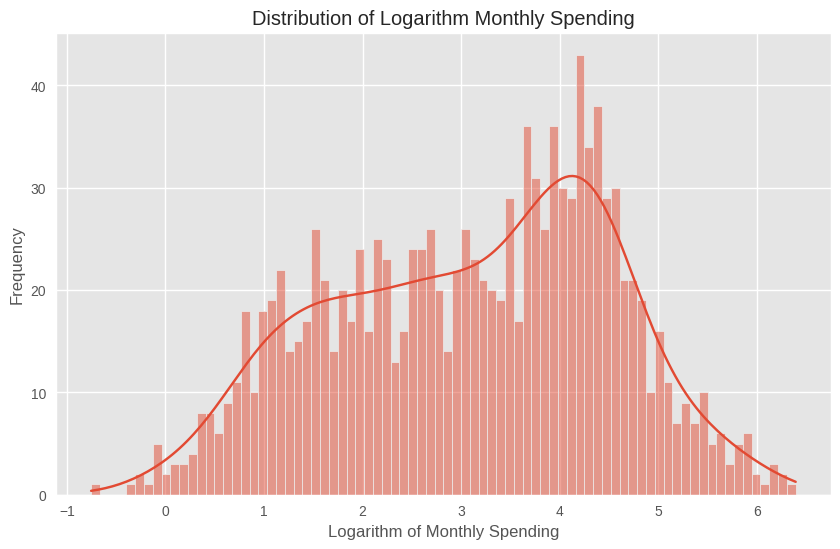

In [1022]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(np.log(data_outliers_cleaned['Monthly_Spending']), bins = 80, kde=True)

# Adding labels and title
plt.xlabel('Logarithm of Monthly Spending')
plt.ylabel('Frequency')
plt.title('Distribution of Logarithm Monthly Spending')

# Show the plot
plt.show()

It is still roughly skewed but probally better now.

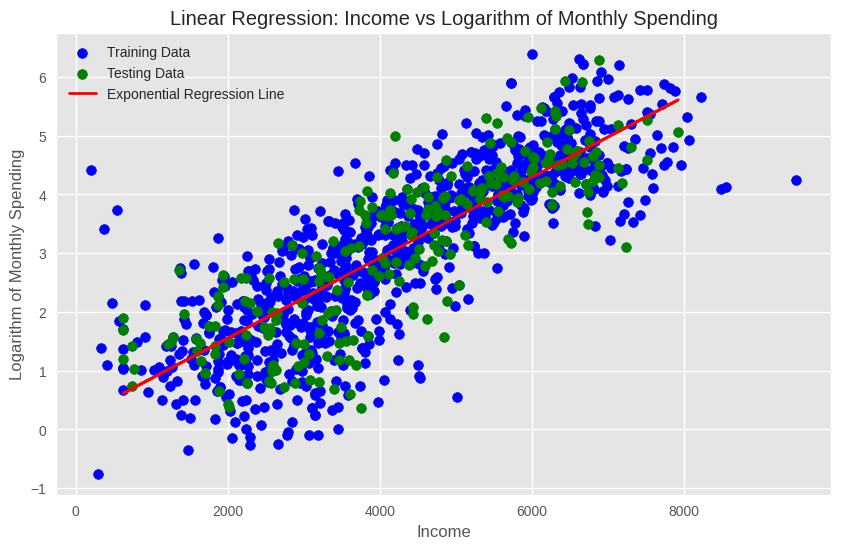

Test Report:
                            OLS Regression Results                            
Dep. Variable:       Monthly_Spending   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     2123.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):          3.09e-247
Time:                        21:27:05   Log-Likelihood:                -1176.1
No. Observations:                 979   AIC:                             2356.
Df Residuals:                     977   BIC:                             2366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1869      0.068      2

In [1023]:
# Prepare the data
X = data_outliers_cleaned[['Income']]/12  # Feature (predictor variable). Performe linear regression on monthly income for easier inepretation
y = data_outliers_cleaned['Monthly_Spending'] # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model with log-transformed target variable
y_train_log = np.log(y_train)  # Log-transforming the target variable
X_train = sm.add_constant(X_train)  # Adding a constant term
model = sm.OLS(y_train_log, X_train).fit()

# Make predictions
X_test = sm.add_constant(X_test)  # Adding a constant term
y_pred_log = model.predict(X_test)
y_test_log = np.log(y_test)

# Visualize the results
plt.figure(figsize=(10, 6))

# Plotting the training data
plt.scatter(X_train.iloc[:, 1], y_train_log, color='blue', label='Training Data')

# Plotting the testing data
plt.scatter(X_test.iloc[:, 1], y_test_log, color='green', label='Testing Data')

# Plotting the regression line
plt.plot(X_test.iloc[:, 1], y_pred_log, color='red', linewidth=2, label='Exponential Regression Line')

plt.title('Linear Regression: Income vs Logarithm of Monthly Spending')
plt.xlabel('Income')
plt.ylabel('Logarithm of Monthly Spending')
plt.legend()
plt.grid(True)
plt.show()

# Generate a test report
print("Test Report:")
print(model.summary())

# Evaluation metrics on testing set
mse = mean_squared_error(y_test_log, y_pred_log)
r2 = r2_score(y_test_log, y_pred_log)

print()
print('Evaluation metrics on testing set:')
print(f"Mean Squared Error of Testing Set: {mse}")
print(f"R-squared of Testing Set: {r2}")

The coefficient related to monthly income is positive and statistically significant.

For every one-unit increase in Monthly Income (in USD), the natural logarithm of Total Spent is predicted to increase by approximately 0.0007.

This means that if Annual Income increases by $100, the Monthly Spending is predicted to increase by e^0.06 - 1 ≈ 7.25%.

#### Income ~ % Spending on Liquor

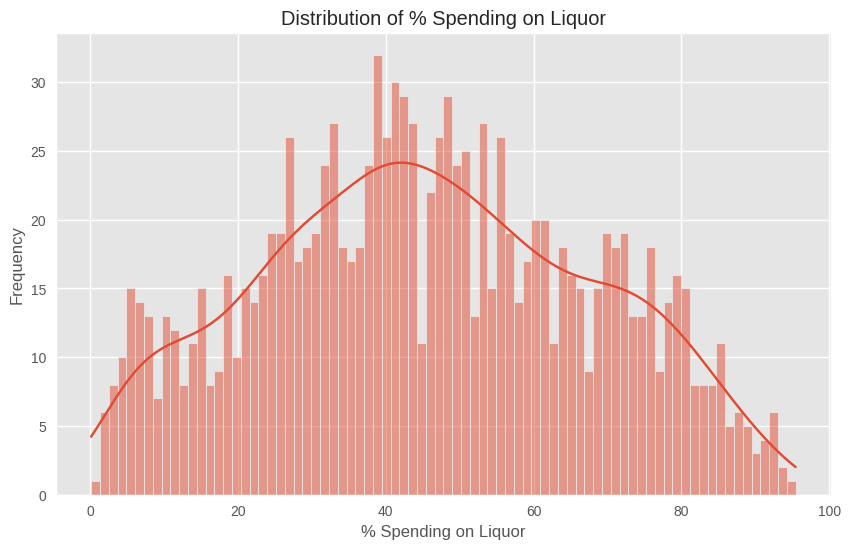

In [1024]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_outliers_cleaned['Liquor']/data_outliers_cleaned['Total_Spending']*100, bins = 80, kde=True)

# Adding labels and title
plt.xlabel('% Spending on Liquor')
plt.ylabel('Frequency')
plt.title('Distribution of % Spending on Liquor')

# Show the plot
plt.show()

The distribution is not close to normal but quite symmetry. Thus log transformation is not neccessary.

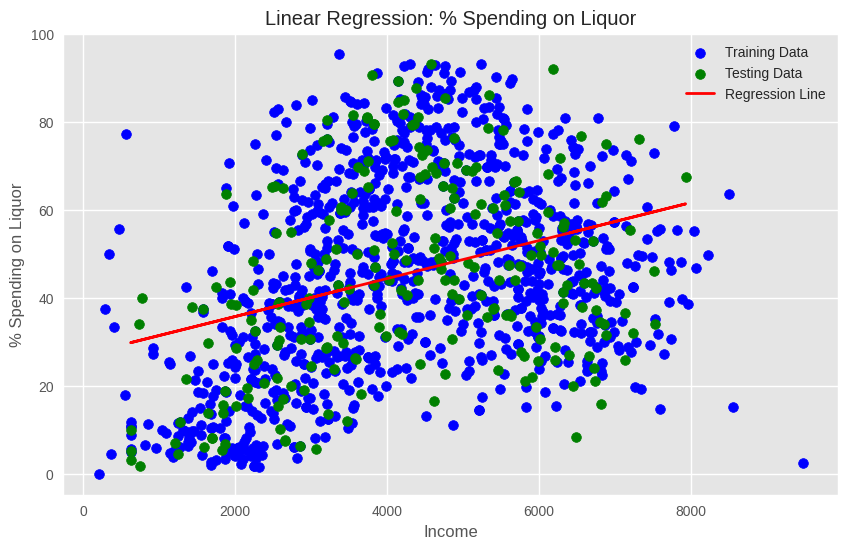

Test Report:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     124.0
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           3.34e-27
Time:                        21:27:06   Log-Likelihood:                -4369.7
No. Observations:                 979   AIC:                             8743.
Df Residuals:                     977   BIC:                             8753.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.1739      1.787     15

In [1025]:
# Prepare the data
X = data_outliers_cleaned[['Income']]/12  # Feature (predictor variable). Using Monthly Income for easier interpretation
y = data_outliers_cleaned['Liquor']/data_outliers_cleaned['Total_Spending']*100  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
X_train = sm.add_constant(X_train)  # Adding a constant term
model = sm.OLS(y_train, X_train).fit()

# Make predictions
X_test = sm.add_constant(X_test)  # Adding a constant term
y_pred = model.predict(X_test)

# Visualize the results
plt.figure(figsize=(10, 6))

# Plotting the training data
plt.scatter(X_train.iloc[:, 1], y_train, color='blue', label='Training Data')

# Plotting the testing data
plt.scatter(X_test.iloc[:, 1], y_test, color='green', label='Testing Data')

# Plotting the regression line
plt.plot(X_test.iloc[:, 1], y_pred, color='red', linewidth=2, label='Regression Line')

plt.title('Linear Regression: % Spending on Liquor')
plt.xlabel('Income')
plt.ylabel('% Spending on Liquor')
plt.legend()
plt.grid(True)
plt.show()

# Generate a test report
print("Test Report:")
print(model.summary())

# Evaluation metrics on testing set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print()
print('Evaluation metrics on testing set:')
print(f"Mean Squared Error of Testing Set: {mse}")
print(f"R-squared of Testing Set: {r2}")

The coefficient related to monthly income is positive and statistically significant.

For every $100 increase in Monthly Income (in USD), % Spending on Liquor is predicted to increase by ~ 1%

### Average monthly spending by marital status and number of children

In [1026]:
average_spent_by_children = data_outliers_cleaned.groupby(['Marital_Status', 'Number_Of_Children'])['Monthly_Spending'].mean().reset_index()

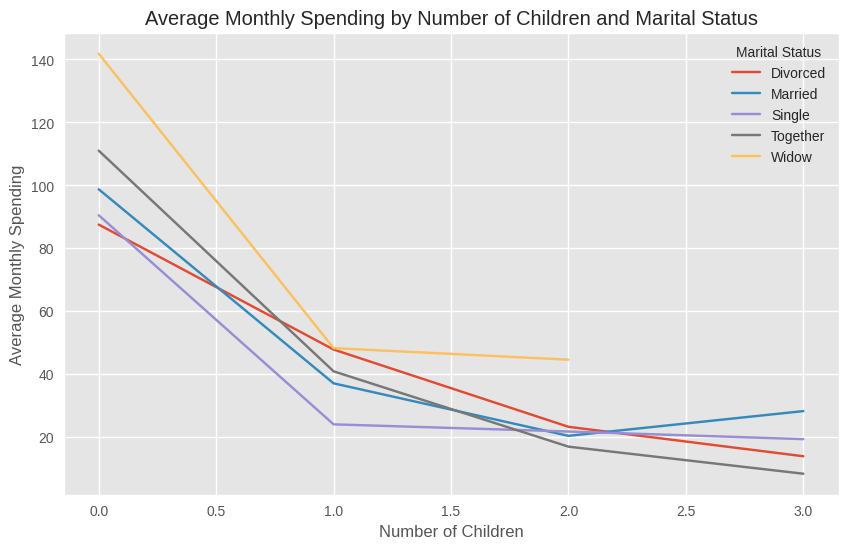

In [1027]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Number_Of_Children', y='Monthly_Spending', hue='Marital_Status', data=average_spent_by_children)
plt.title('Average Monthly Spending by Number of Children and Marital Status')
plt.xlabel('Number of Children')
plt.ylabel('Average Monthly Spending')
plt.legend(title='Marital Status')
plt.show()

All marital status groups seem to spend less when they have more children.

### Average Number of Purchases by Academic Levels

In [1028]:
# Group by 'Academic_Level' and sum the numeric purchase columns
average_purchasing_sources_academic = data.groupby('Academic_Level')[['Num_Web_Purchases', 'Num_Catalog_Purchases', 'Num_Store_Purchases']].mean()

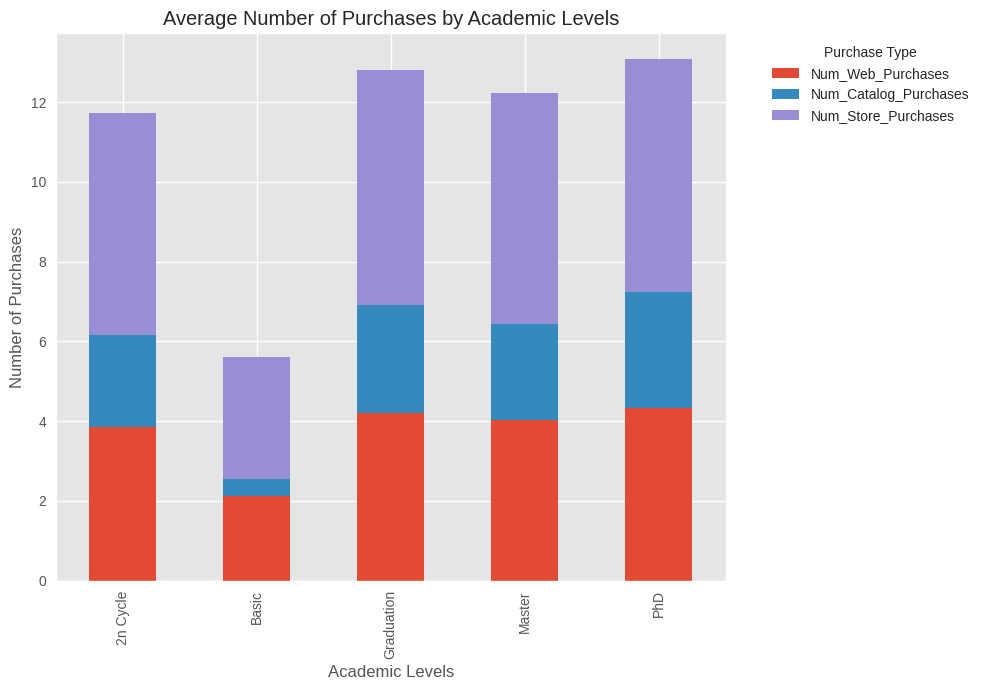

In [1029]:
# Plot the stacked bar chart
ax = average_purchasing_sources_academic.plot(kind='bar', stacked=True, figsize=(10, 7))

# Adding titles and labels
plt.title('Average Number of Purchases by Academic Levels')
plt.xlabel('Academic Levels')
plt.ylabel('Number of Purchases')

# Adding legend
plt.legend(title='Purchase Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

Most purchases comes from the store.

It seems like basic is the least purchasing group, which is consistent with their seemingly low income (see the previous plot).

### Average Deal-Total Purchase Rate by marital status and number of children

Deal-Total Purchase Rate = Number of Deals/Total purchases

In [1030]:
data_outliers_cleaned['Deal_Total_Rate'] = data_outliers_cleaned['Num_Deals_Purchases']/data_outliers_cleaned['Total_Purchase']*100
data['Deal_Total_Rate'] = data['Num_Deals_Purchases']/data['Total_Purchase']*100

In [1031]:
deal_total_rate_by_children = data_outliers_cleaned.groupby(['Marital_Status', 'Number_Of_Children'])['Deal_Total_Rate'].mean().reset_index()

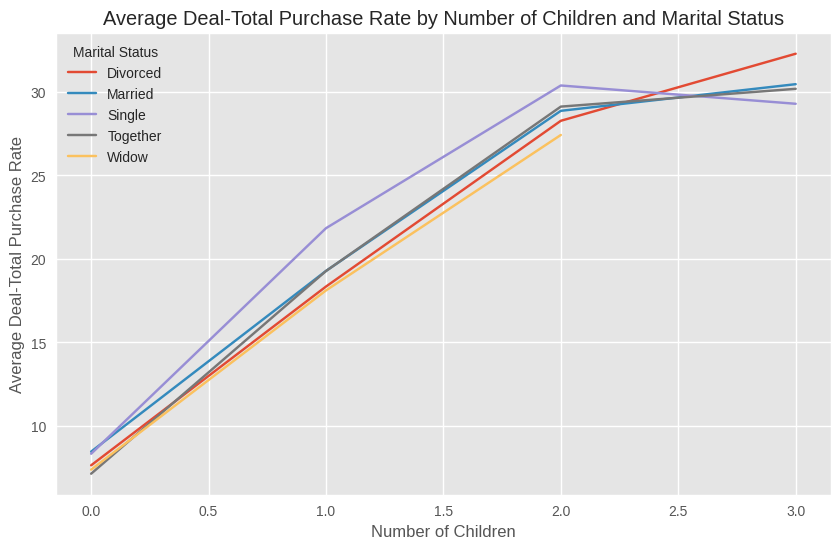

In [1032]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Number_Of_Children', y='Deal_Total_Rate', hue='Marital_Status', data=deal_total_rate_by_children)
plt.title('Average Deal-Total Purchase Rate by Number of Children and Marital Status')
plt.xlabel('Number of Children')
plt.ylabel('Average Deal-Total Purchase Rate')
plt.legend(title='Marital Status')
plt.show()

All groups seem to accept larger amount of discounts when they have more children, except for Single group which slighly decrease when number of children increase from 2 to 3.

### Average Interval between Purchases

In [1033]:
# Calculate the average interval
data_outliers_cleaned['Average_Interval'] = data_outliers_cleaned['Days_Since_Registration'] / data_outliers_cleaned['Total_Purchase']

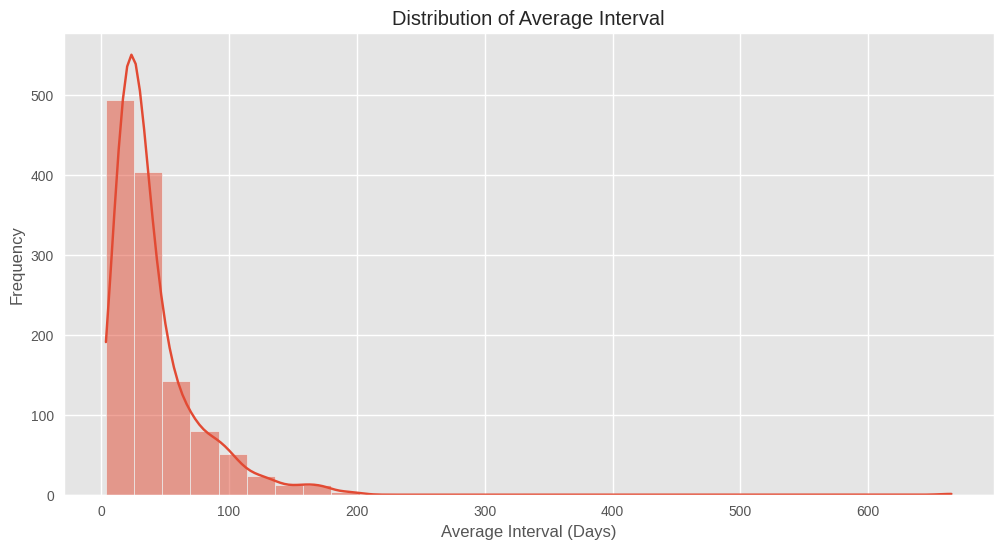

In [1034]:
# Plot the distribution of the average interval
plt.figure(figsize=(12, 6))
sns.histplot(data_outliers_cleaned['Average_Interval'], bins=30, kde=True)
plt.title('Distribution of Average Interval')
plt.xlabel('Average Interval (Days)')
plt.ylabel('Frequency')
plt.show()

In [1035]:
data_outliers_cleaned['Average_Interval'].describe()

count    1224.000000
mean             inf
std              NaN
min         3.807692
25%        20.022059
50%        30.000000
75%        49.770833
max              inf
Name: Average_Interval, dtype: float64

On average, people have 37 days interval between two purchases. The distribution plot is skewed to the right with some extreme values. Over 25% of people have average interval > 50 days. Some people have average interval > 100 days. The large values of average interval might indicate that these customers are no longer have the intention to purchase products from the business.

### Recency-Average Interval Rate

In [1036]:
data_outliers_cleaned['recency_avg_interval_rate'] = data_outliers_cleaned['Recency']/data_outliers_cleaned['Average_Interval']

In [1037]:
data_outliers_cleaned[data_outliers_cleaned['recency_avg_interval_rate'] == data_outliers_cleaned['recency_avg_interval_rate'].max()][['Registration_Time', 'Days_Since_Registration', 'Recency', 'Average_Interval', 'recency_avg_interval_rate']]

Registration_Time  Days_Since_Registration  Recency  Average_Interval  \
569        2023-06-27                       99     99.0          3.807692   

     recency_avg_interval_rate  
569                       26.0

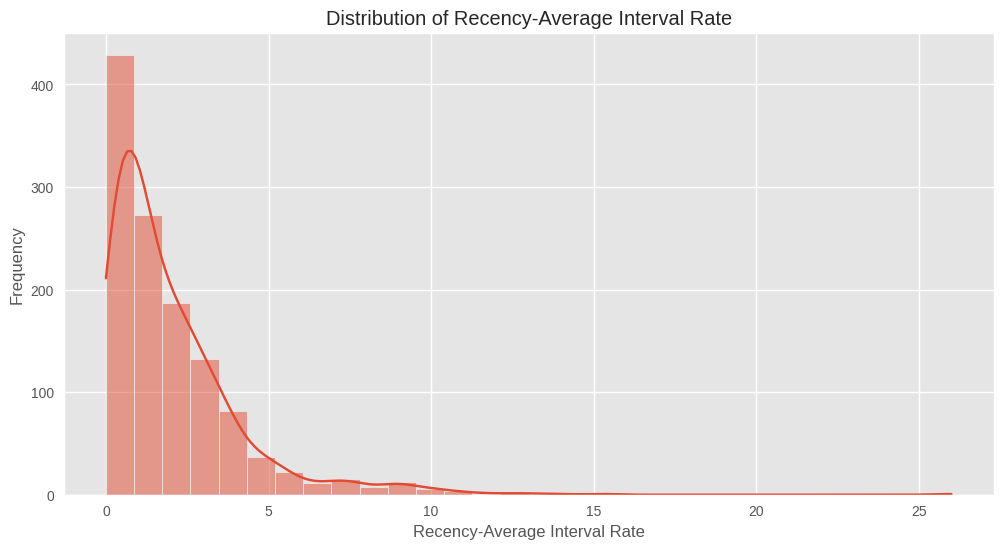

In [1038]:
# Plot the distribution of recency/avg interval
plt.figure(figsize=(12, 6))
sns.histplot(data_outliers_cleaned['recency_avg_interval_rate'], bins=30, kde=True)
plt.title('Distribution of Recency-Average Interval Rate')
plt.xlabel('Recency-Average Interval Rate')
plt.ylabel('Frequency')
plt.show()

There are some Recency-Average Interval Rate > 5, which might belong to no longer active customers.

## **Clustering**

### Principal component analysis (PCA)

Principal Component Analysis (PCA) is a technique used for dimensionality reduction. It transforms a large set of variables into a smaller one that retains most of the original information. PCA can be used in an unsupervised machine learning problem for feature selection.

**Key Steps in PCA:**
1. **Standardization**: Standardize the data to have a mean of 0 and a standard deviation of 1.
2. **Select Principal Components**: Choose the top principal components based on the eigenvalues.

#### Preprocessing

In [ ]:
# Drop unnecessary columns
data_clustering = data_outliers_cleaned.drop(columns = ['ID', 'Year_Of_Birth', 'Registration_Time', 'Promo_40', 'Year_Register',
                                                        'Month_Register', 'Total_Purchase', 'Income_Level',
                                                        'Month_Since_Registration', 'Total_Spending', 'Monthly_Spending',
                                                        'Deal_Total_Rate', 'Average_Interval', 'recency_avg_interval_rate'
                                                        ])

In [ ]:
data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 0 to 3066
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Academic_Level           2204 non-null   object 
 1   Income                   2204 non-null   float64
 2   Recency                  2204 non-null   float64
 3   Liquor                   2204 non-null   float64
 4   Vegetables               2204 non-null   float64
 5   Pork                     2204 non-null   float64
 6   Seafood                  2204 non-null   float64
 7   Candy                    2204 non-null   float64
 8   Jewellery                2204 non-null   float64
 9   Num_Deals_Purchases      2204 non-null   float64
 10  Num_Web_Purchases        2204 non-null   float64
 11  Num_Catalog_Purchases    2204 non-null   float64
 12  Num_Store_Purchases      2204 non-null   float64
 13  Num_Web_Visits_Month     2204 non-null   float64
 14  Promo_30                 2204

In [ ]:
obj_list = data_clustering.select_dtypes(include=['object']).columns.tolist()
print(obj_list)

['Academic_Level', 'Gender', 'Phone', 'Payment_Method', 'Marital_Status']


In [ ]:
# Encode object columns
LE=LabelEncoder()
data_model = data_clustering.copy()
for i in obj_list:
    data_model[i]=data_model[[i]].apply(LE.fit_transform)

In [ ]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 0 to 3066
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Academic_Level           2204 non-null   int64  
 1   Income                   2204 non-null   float64
 2   Recency                  2204 non-null   float64
 3   Liquor                   2204 non-null   float64
 4   Vegetables               2204 non-null   float64
 5   Pork                     2204 non-null   float64
 6   Seafood                  2204 non-null   float64
 7   Candy                    2204 non-null   float64
 8   Jewellery                2204 non-null   float64
 9   Num_Deals_Purchases      2204 non-null   float64
 10  Num_Web_Purchases        2204 non-null   float64
 11  Num_Catalog_Purchases    2204 non-null   float64
 12  Num_Store_Purchases      2204 non-null   float64
 13  Num_Web_Visits_Month     2204 non-null   float64
 14  Promo_30                 2204

In [ ]:
# Scaling
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data_model), columns = data_model.columns)

In [ ]:
scaled_data.head()

Academic_Level    Income   Recency    Liquor  Vegetables  ...  \
0            0.50  0.529838  0.373737  0.528466    0.000000  ...   
1            0.50  0.521080  0.929293  0.336236    0.060302  ...   
2            0.00  0.696038  0.656566  0.208305    0.130653  ...   
3            0.75  0.350800  0.121212  0.009377    0.035176  ...   
4            1.00  0.496438  0.555556  0.630275    0.070352  ...   

   Payment_Method  Days_Since_Registration  Marital_Status  \
0            0.00                 0.974249            0.25   
1            0.50                 0.526466            0.25   
2            0.75                 0.590844            0.50   
3            0.75                 0.781116            0.75   
4            0.00                 0.922747            0.00   

   Number_Of_Children       Age  
0            0.333333  0.296296  
1            0.333333  0.481481  
2            0.000000  0.888889  
3            0.333333  0.555556  
4            0.333333  0.222222  

[5 rows x 26 columns]

#### Dimensionality reduction

In [ ]:
pca = PCA()
pca_data = pd.DataFrame(pca.fit_transform(scaled_data))

In [ ]:
# Print number of features
len(pca.explained_variance_ratio_)

26

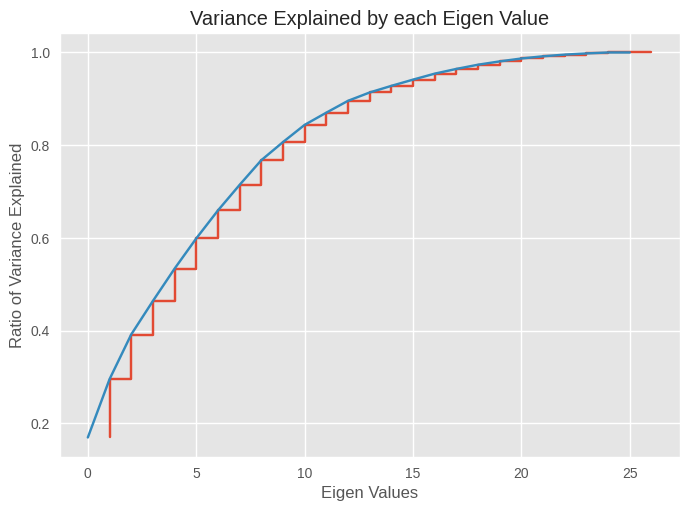

In [ ]:
plt.step(list(range(1,27)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Eigen Values')
plt.ylabel('Ratio of Variance Explained')
plt.title('Variance Explained by each Eigen Value')
plt.show()

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.16978171, 0.29527983, 0.39177572, 0.46400819, 0.53373346,
       0.59892639, 0.65927183, 0.71440464, 0.76759791, 0.80667807,
       0.84384913, 0.87016648, 0.89571028, 0.91371805, 0.92795541,
       0.94139007, 0.95431501, 0.96451055, 0.9736032 , 0.98077026,
       0.98701607, 0.9917618 , 0.99535842, 0.99792651, 1.        ,
       1.        ])

We can see that ~ 95% of variance are explained by the first 17 features, so I will drop the rest.

In [ ]:
pca_data = pca_data.drop(columns = [17, 18, 19, 20, 21, 22, 23, 24, 25])
pca_data.head()

0         1         2         3         4   ...        12        13  \
0  0.237573 -0.517936  0.429198  0.436971 -0.282636  ...  0.288859 -0.119410   
1  0.141173 -0.019751  0.017876 -0.091487 -0.426012  ...  0.223706 -0.139870   
2  0.748793  0.458688 -0.305157  0.521289  0.161091  ... -0.089370 -0.083192   
3 -0.339903  0.492530 -0.161555 -0.232327 -0.234966  ... -0.045122  0.004348   
4  0.472781  0.005691  0.474057  0.076402 -0.586771  ...  0.141543 -0.025792   

         14        15        16  
0  0.347158 -0.054505  0.098147  
1  0.055913 -0.093530  0.041048  
2 -0.046661 -0.281638 -0.311264  
3 -0.039565  0.016371 -0.007171  
4  0.380077 -0.251827  0.013971  

[5 rows x 17 columns]

### K-Means Clustering

K-Means clustering is a popular unsupervised machine learning algorithm used for partitioning data into K clusters. It works by iteratively assigning each data point to the nearest cluster centroid and then recalculating the centroids based on the mean of the assigned points.

K-Means clustering is enhanced by the Elbow Method, which helps determine the optimal number of clusters (K). The Elbow Method involves plotting the sum of squared distances from each point to its assigned cluster centroid against different values of K. The point where the plot forms an "elbow" shape indicates the optimal K, where increasing K further no longer significantly reduces the sum of squared distances. This method provides a visual aid for selecting the appropriate number of clusters in K-Means clustering.


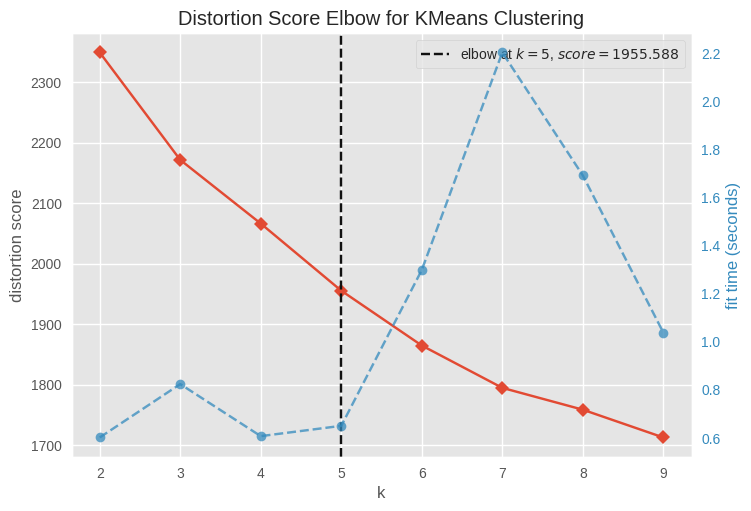

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=4), k=(2, 10))

In [ ]:
kelbow_visualizer(KMeans(random_state=4), pca_data, k=(2,10))

The plot suggest using 5 clusters.

In [ ]:
optimal_k = 5  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_data.values)
labels = kmeans.labels_

# Add cluster labels back to the original DataFrame or create a new DataFrame with labels
data_clustering['Cluster'] = labels

In [ ]:
data_clustering.head()

Academic_Level   Income  Recency  Liquor  Vegetables  ...  \
0     Graduation  61074.0     37.0   790.0         2.0  ...   
1     Graduation  60093.0     92.0   503.0        14.0  ...   
2       2n Cycle  79689.0     65.0   312.0        28.0  ...   
3         Master  41021.0     12.0    15.0         9.0  ...   
4            PhD  57333.0     55.0   942.0        16.0  ...   

   Days_Since_Registration  Marital_Status  Number_Of_Children   Age  Cluster  
0                      778         Married                   1  30.0        1  
1                      465         Married                   1  35.0        1  
2                      510          Single                   0  46.0        3  
3                      643        Together                   1  37.0        2  
4                      742        Divorced                   1  28.0        1  

[5 rows x 27 columns]

## **Segmentations**

### Clusters' distributions

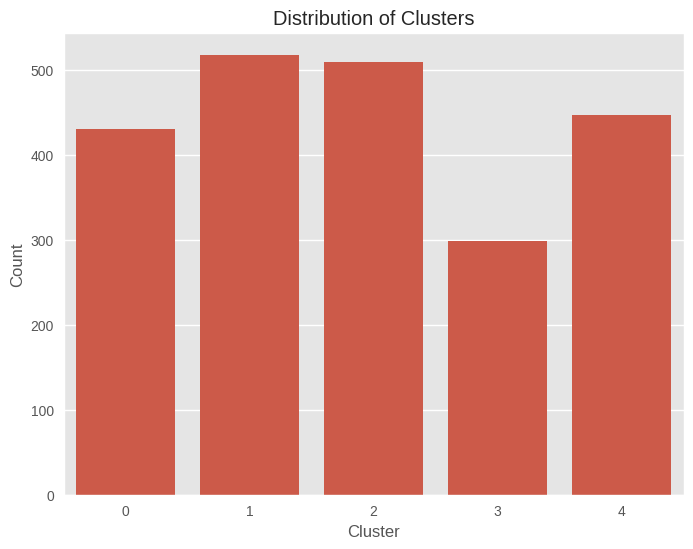

In [ ]:
# Plotting the count plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=data_clustering)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

The clusters distribute quite evenly.

In [ ]:
data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 0 to 3066
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Academic_Level           2204 non-null   object 
 1   Income                   2204 non-null   float64
 2   Recency                  2204 non-null   float64
 3   Liquor                   2204 non-null   float64
 4   Vegetables               2204 non-null   float64
 5   Pork                     2204 non-null   float64
 6   Seafood                  2204 non-null   float64
 7   Candy                    2204 non-null   float64
 8   Jewellery                2204 non-null   float64
 9   Num_Deals_Purchases      2204 non-null   float64
 10  Num_Web_Purchases        2204 non-null   float64
 11  Num_Catalog_Purchases    2204 non-null   float64
 12  Num_Store_Purchases      2204 non-null   float64
 13  Num_Web_Visits_Month     2204 non-null   float64
 14  Promo_30                 2204

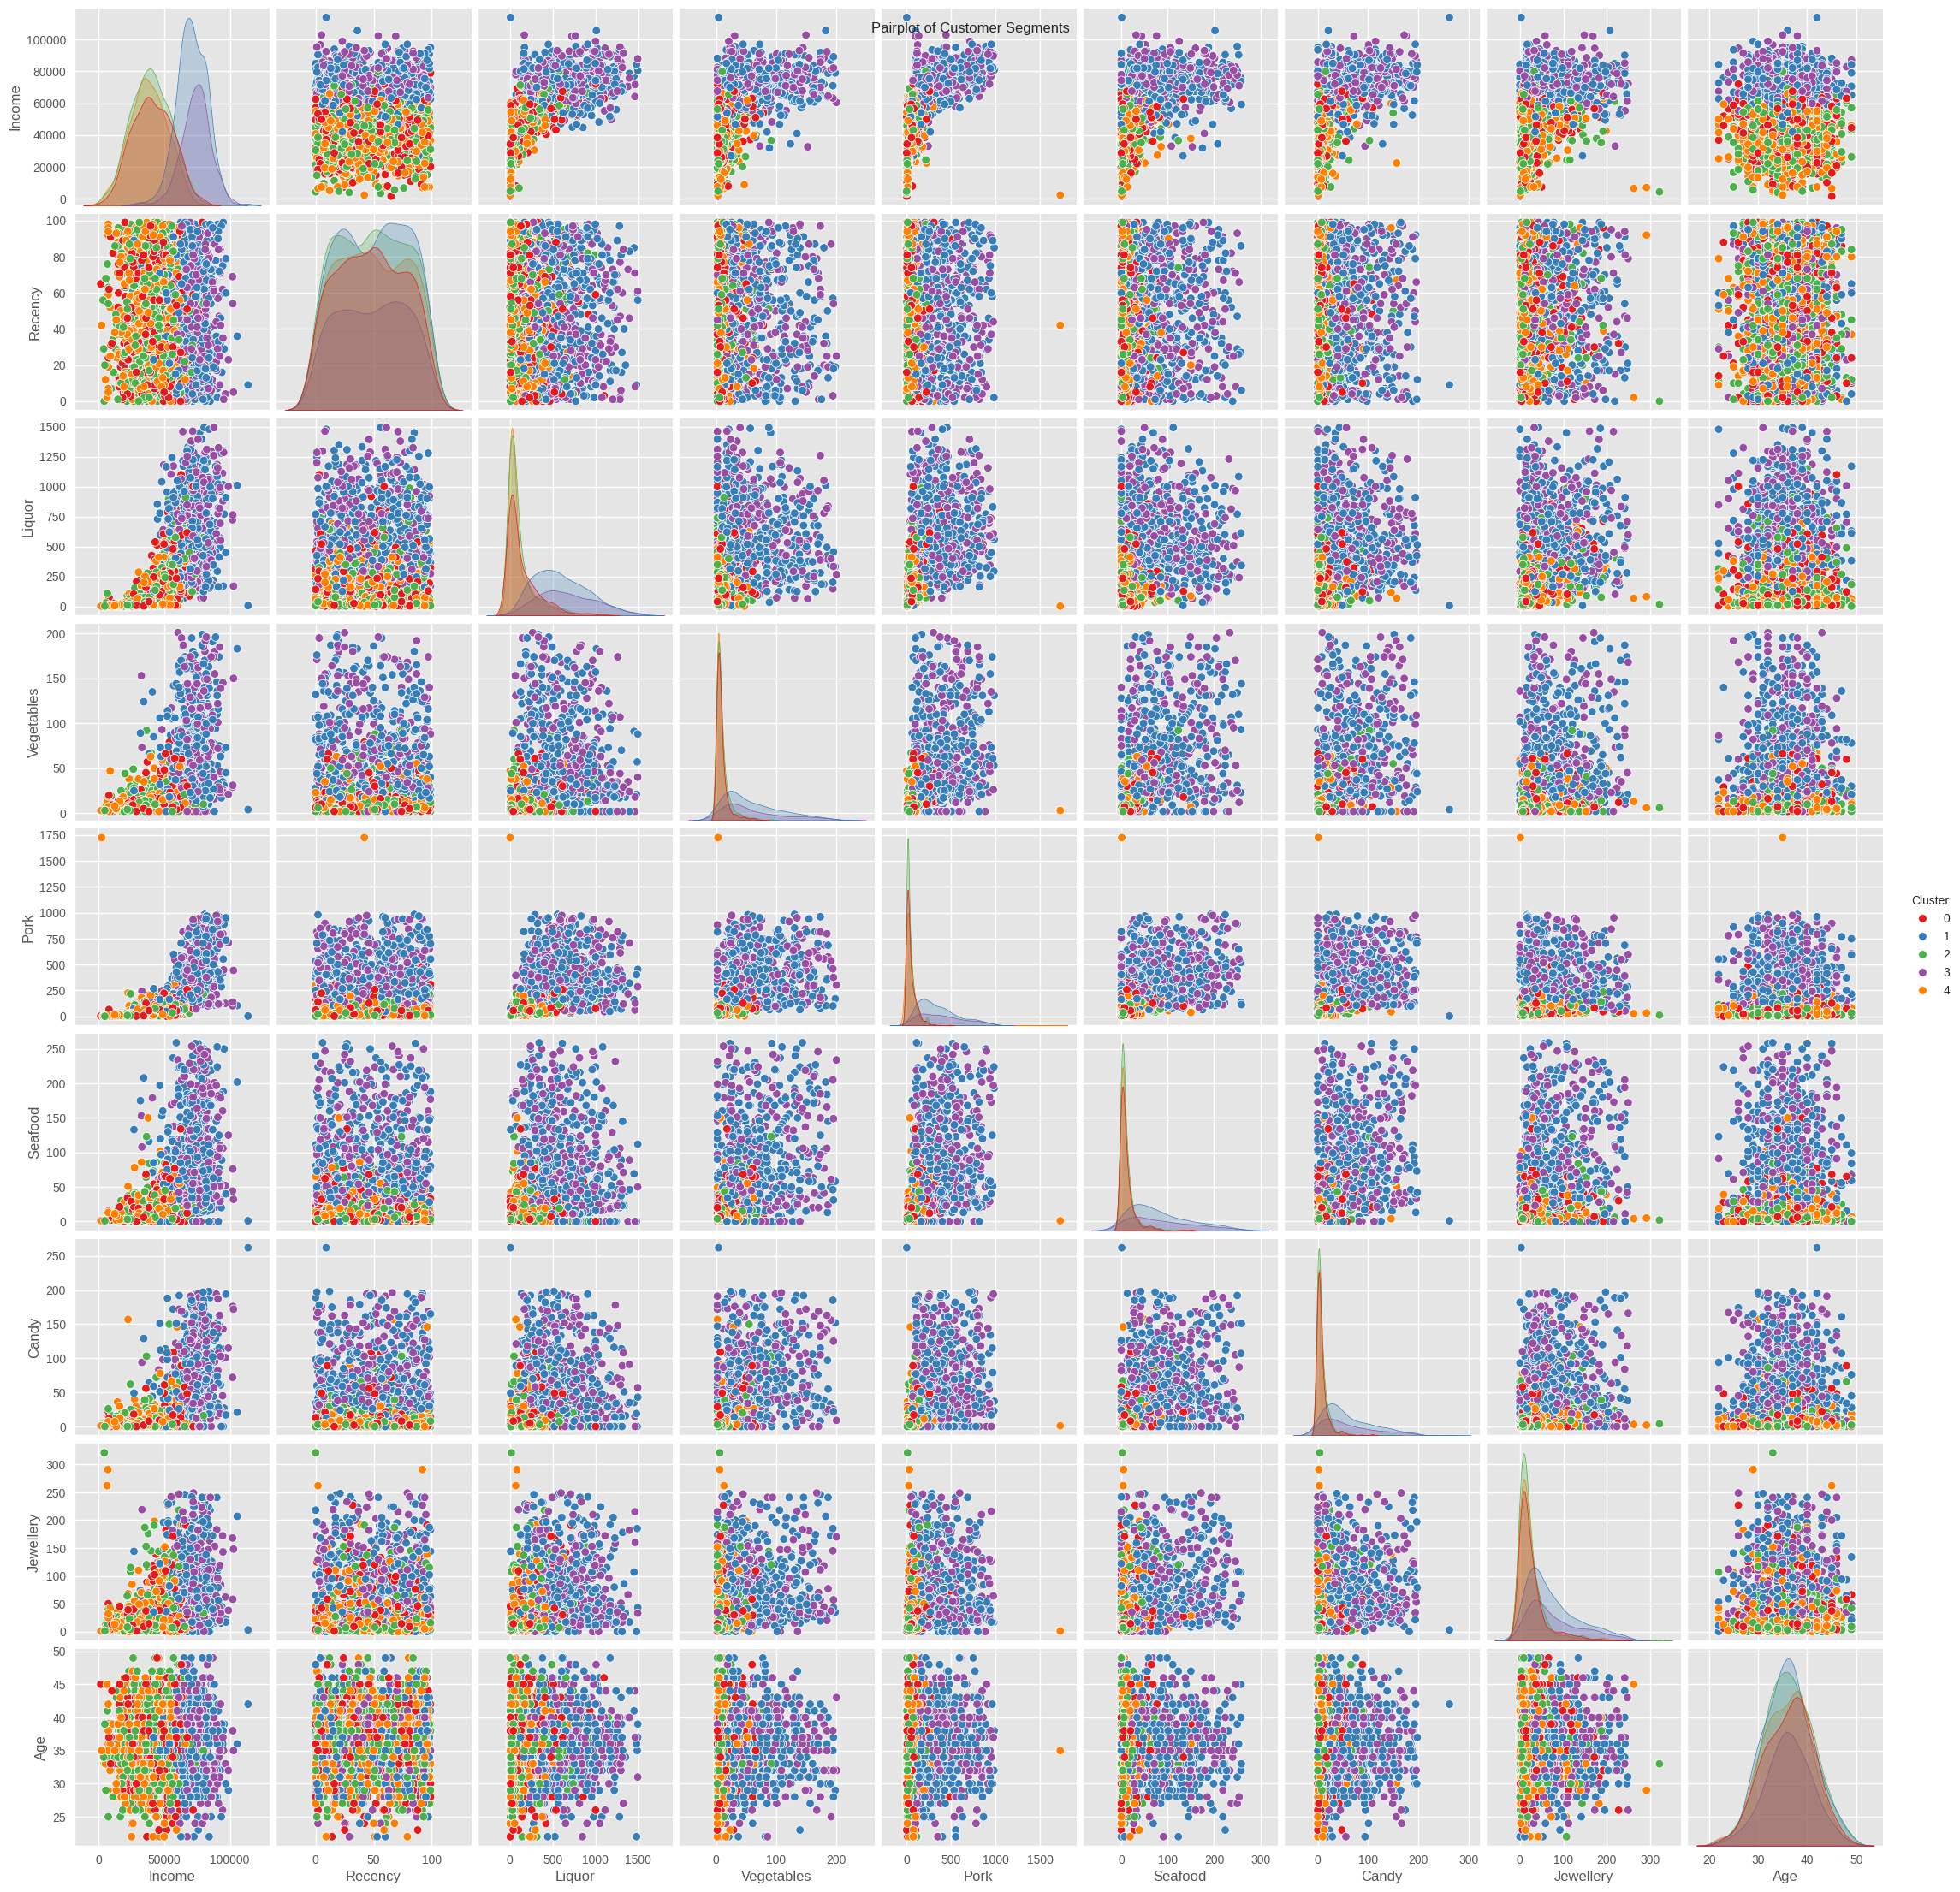

In [ ]:
# Select relevant columns for pairplot
cols_for_pairplot = ['Academic_Level', 'Income', 'Recency', 'Liquor', 'Vegetables',
                     'Pork', 'Seafood', 'Candy', 'Jewellery', 'Age', 'Cluster']

# Create pairplot
sns.pairplot(data_clustering[cols_for_pairplot], hue='Cluster', palette='Set1')
plt.suptitle('Pairplot of Customer Segments')
plt.show()

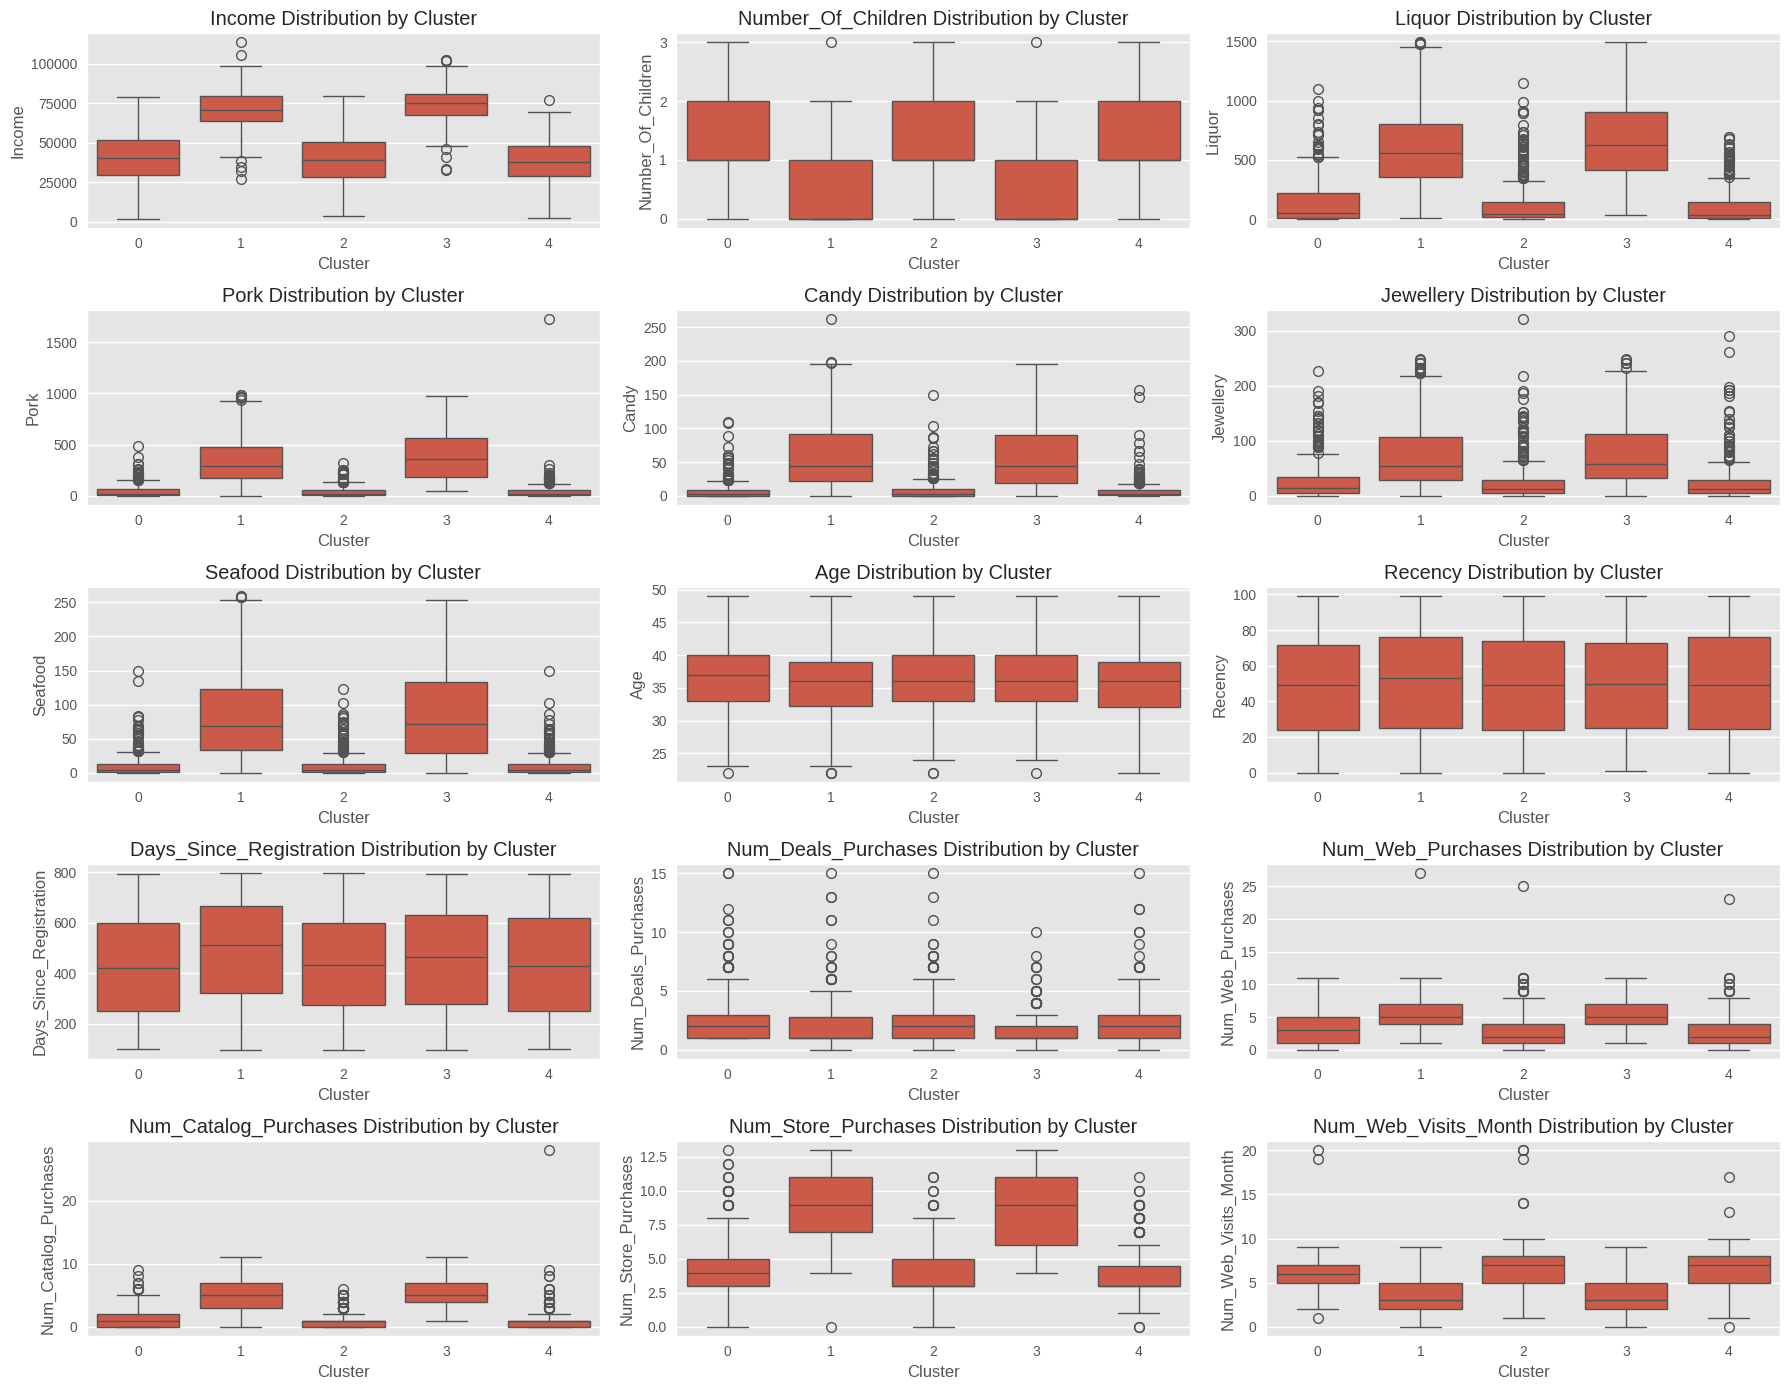

In [ ]:
# List of columns to plot
cols = ['Income', 'Number_Of_Children', 'Liquor', 'Pork', 'Candy', 'Jewellery',
        'Seafood', 'Age', 'Recency', 'Days_Since_Registration', 'Num_Deals_Purchases',
        'Num_Web_Purchases', 'Num_Catalog_Purchases', 'Num_Store_Purchases',
        'Num_Web_Visits_Month']

# Plotting distribution plots for each column
plt.figure(figsize=(18, 14))
for i, col in enumerate(cols, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x='Cluster', y=col, data=data_clustering)
    plt.title(f'{col} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

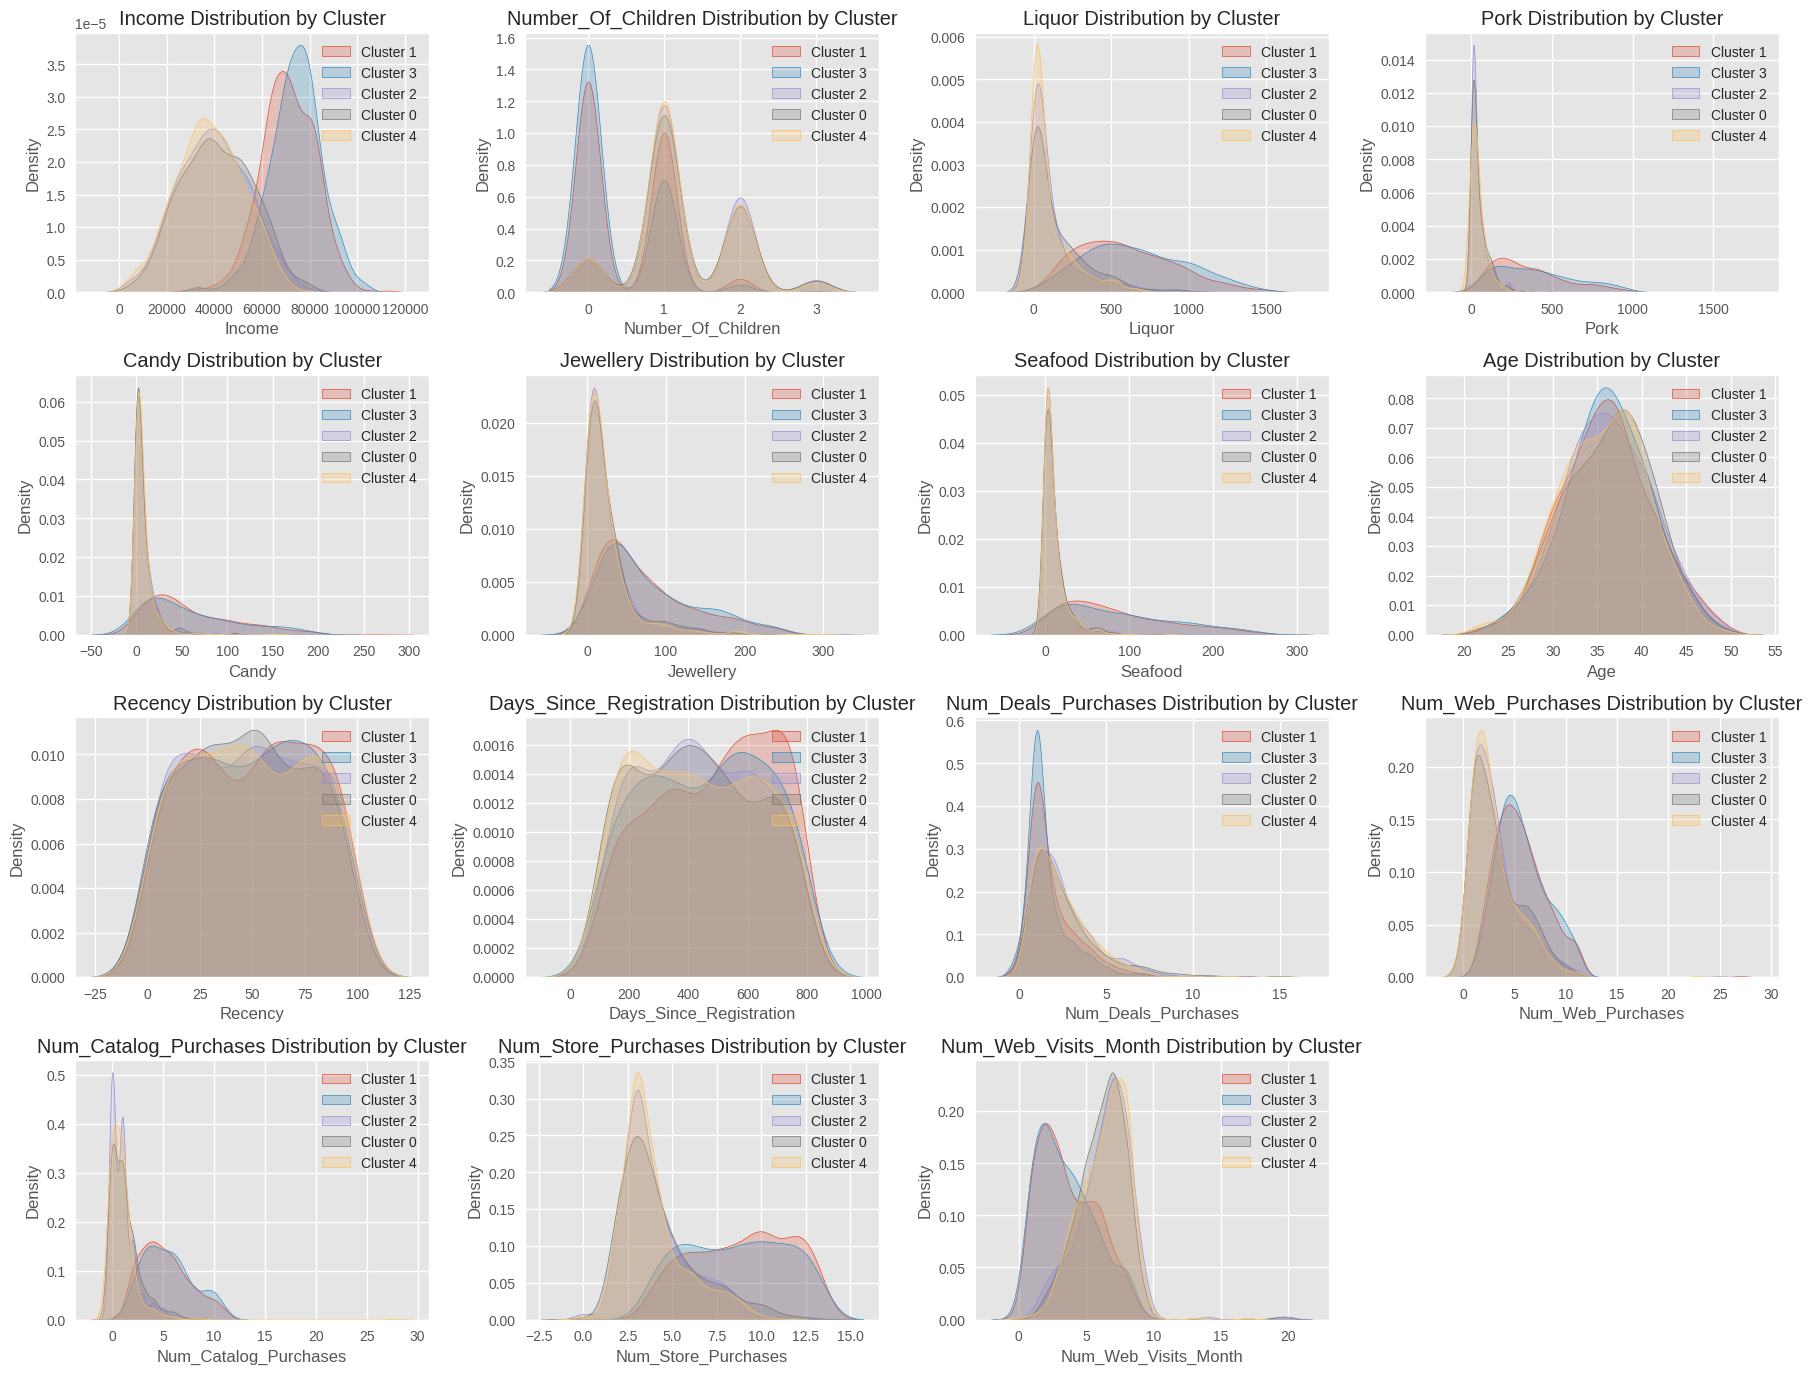

In [ ]:
# Plotting KDE plots for each column by cluster with shaded area under the curve
plt.figure(figsize=(18, 14))
for i, col in enumerate(cols, 1):
    plt.subplot(4, 4, i)
    for cluster in data_clustering['Cluster'].unique():
        sns.kdeplot(data_clustering[data_clustering['Cluster'] == cluster][col], label=f'Cluster {cluster}', fill=True)
    plt.title(f'{col} Distribution by Cluster')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

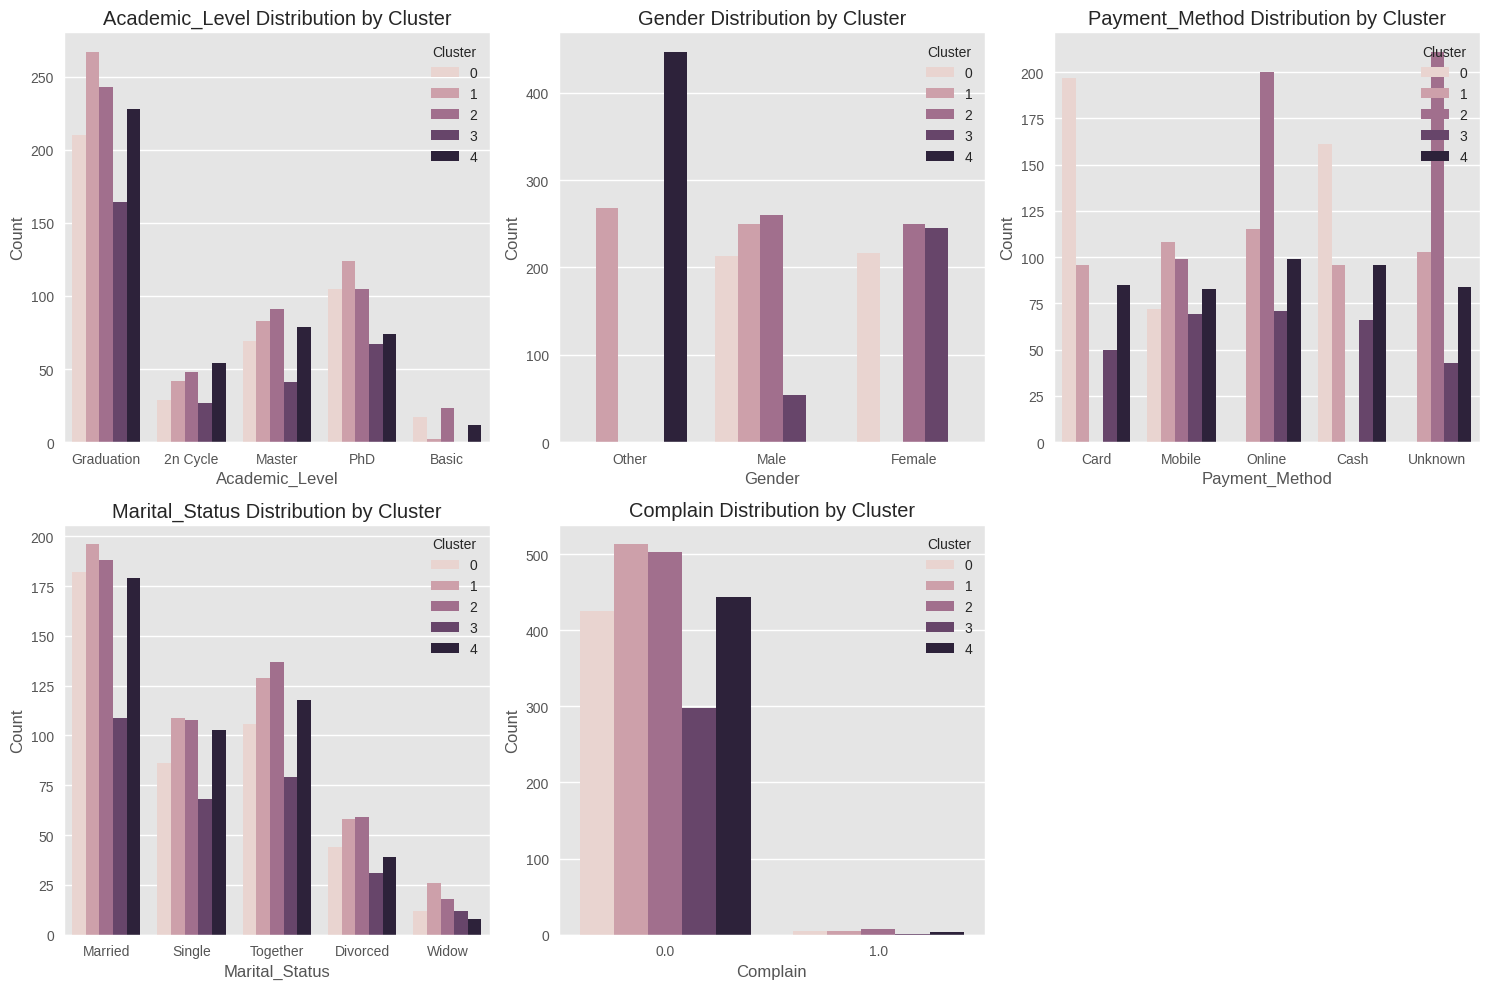

In [ ]:
# List of categorical columns
cat_cols = ['Academic_Level', 'Gender', 'Payment_Method', 'Marital_Status', 'Complain']

# Plotting count plots for each categorical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, hue='Cluster', data=data_clustering)
    plt.title(f'{col} Distribution by Cluster')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Segments' profiles

Let's generalize these clusters.

**Cluster 0: Frugal Family Shoppers**
- **Income:** Lower income group, spend low.
- **Children:** Typically have 1-2 children, with some having 3.
- **Shopping Behavior:** Not very prone to discounts, prefer in-store and online transactions over catalog.
- **Web visits:** Despite infrequent purchases, they visit the website regularly.
- **Gender:** Only male and female, no other (e.g. non-binary) types.
- **Payment Method:** Mostly pay with Card or Cash.

**Cluster 1: Wealthy Scholars**
- **Income:** Higher income group, spend high.
- **Children:** Majority have no or only 1 child.
- **Days Since Registration:** Many are long-time customers.
- **Shopping Behavior:** Majority once use 1-2 discount. Purchases channels spread evenly.
- **Number of Deals Purchases:** Almost all made at least 1 or 2 deals.
- **Web visits:** Despite frequent purchases, they visit the website not so oftenly
- **Academic Level:** High levels of education with advanced degrees.
- **Gender:** No female.

**Cluster 2: Tech-Savvy Online Shoppers**
- **Income:** Lower income group, spend low.
- **Children:** Typically have 1-2 children, with some having 3.
- **Shopping Behavior:** Prone to discount, mostly making transactions in-store and on web, not on catalog.
- **Web visits:** Despite infrequent purchases, they visit the website regularly.
- **Gender:** Only male and female, no other (e.g. non-binary) types.
- **Payment Method:** Mostly pay with Online, some pay with Mobile.

**Cluster 3: High-Earning Women**
- **Income:** Higher income group with diverse spending patterns.
- **Children:** Majority have no or only 1 child.
- **Shopping Behavior:** Majority once use 1-2 discount. Purchases channels spread evenly.
- **Web visits:** Despite frequent purchases, they visit the website not so oftenly
- **Gender:** Significant female representation, minimal other types.

**Cluster 4: Diverse Shopper**
- **Income:** Lower income group, spend low.
- **Children:** Typically have 1-2 children, with some having 3.
- **Shopping Behavior:** Prone to discount, mostly making transactions in-store and on web, not on catalog.
- **Web visits:** Despite infrequent purchases, they visit the website regularly.
- **Gender:** No male and female, only other (e.g. non-binary) types.